In [1]:
const SAVED_DIR = "/Volumes/Samsung250GB/temperature_model/saved"
include("src/batch_diagnostics.jl")
stan_increment = Day(3)
stan_days = Day(9)
janfirst = Date(2015,1,1)
;

  likely near /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/batch_diagnostics.jl:4
  likely near /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/batch_diagnostics.jl:4


In [2]:
# obtain the list of stations
isdList=TempModel.read_isdList()
# just the Iowa stations
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

# obtain the hourly temperature measurements for those stations
hourly_cat=TempModel.read_Stations(isdSubset)
# mark station 3 (Waterloo) as the test station
itest=3
# separate temperatures into train and test
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
# get the USAF code for the test station
test_usaf=get(isdSubset[itest,:USAF])

# emulate daily Tx/Tn measurement
# hr_measure = Hour(17) # number between 0 and 23
# hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
# TnTx = DataTables.by(hourly_test, :ts_day, df -> DataTable(
#     Tn=minimum(df[:temp].values), 
#     Tx=maximum(df[:temp].values)))
# # add column to test data for TnTx (useful for plotting)
# test_trimmed=join(hourly_test, TnTx, on=:ts_day)
# head(test_trimmed)

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] anynull(::NullableArrays.NullableArray{Float64,1}) at ./deprecated.jl:57
 [3] convert(::Type{Array{Float64,2}}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:545
 [4] convert(::Type{Array{T,2} where T}, ::DataTables.DataTable) at /Users/imolk/Library/Julia/packages/v0.6/DataTables/src/abstractdatatable/abstractdatatable.jl:535
 [5] #read_isdList#18(::String, ::Function) at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:36
 [6] read_isdList() at /Users/imolk/Documents/Harvard/Natesh/temperature_model/src/preprocessing.jl:31
 [7] include_string(::String, ::String) at ./loading.jl:515
 [8] include_string(::Module, ::String, ::String) at /Users/imolk/Library/Julia/packages/v0.6/Compat/src/Compat.jl:407
 [9] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages/v0.6/IJulia/src/execute_re

725480

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=false)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [4]:
all_impt_diagn = Dict{String, Vector{ImputationDiagnostic}}()

Dict{String,Array{ImputationDiagnostic,1}} with 0 entries

In [5]:
import DataFrames

# Getting Tn and Tx

In [6]:
function get_TnTx(temperatures::AbstractVector{Float64}, 
                  ts::AbstractVector{DateTime}, 
                  measure_day::AbstractVector{Date}, 
                  unique_days::AbstractVector{Date})
    ndays = length(unique_days)
    Tn_vec = Vector{Float64}(ndays)
    Tx_vec = Vector{Float64}(ndays)
    buffer_vec = Vector{Base.Dates.TimePeriod}(ndays)
    for (i,day) in enumerate(unique_days)
        # brute force:
        iday = measure_day .== day
        ts_day = ts[iday]
        buffer_start = minimum(ts_day) - minimum(ts)
        buffer_end = maximum(ts) - maximum(ts_day)
        buffer = min(buffer_start, buffer_end)
        day_temps = temperatures[iday]
        Tn_vec[i] = minimum(day_temps)
        Tx_vec[i] = maximum(day_temps)
        buffer_vec[i] = buffer
    end
    TnTx_df = DataFrames.DataFrame(
        day = unique_days,
        Tn = Tn_vec,
        Tx = Tx_vec,
        buffer = buffer_vec
        )
    return TnTx_df
end

get_TnTx (generic function with 1 method)

In [7]:
function get_TnTx(temperatures::AbstractVector{Float64}, 
                  ts::AbstractVector{DateTime}, 
                  hr_measure::Hour)
    measure_day = [TempModel.measurement_date(t, hr_measure) for t in ts]
    unique_days = sort(unique(measure_day))
    return get_TnTx(temperatures, ts, measure_day, unique_days)
end

get_TnTx (generic function with 2 methods)

In [173]:
hours = Hour(0):Hour(1):Hour(23)

0 hours:1 hour:23 hours

In [181]:
TnTx_0 = get_TnTx(hourly_test[:temp].values,
              hourly_test[:ts].values,
              Hour(0))
;

In [182]:
TnTx_23 = get_TnTx(hourly_test[:temp].values,
              hourly_test[:ts].values,
              Hour(23))
;

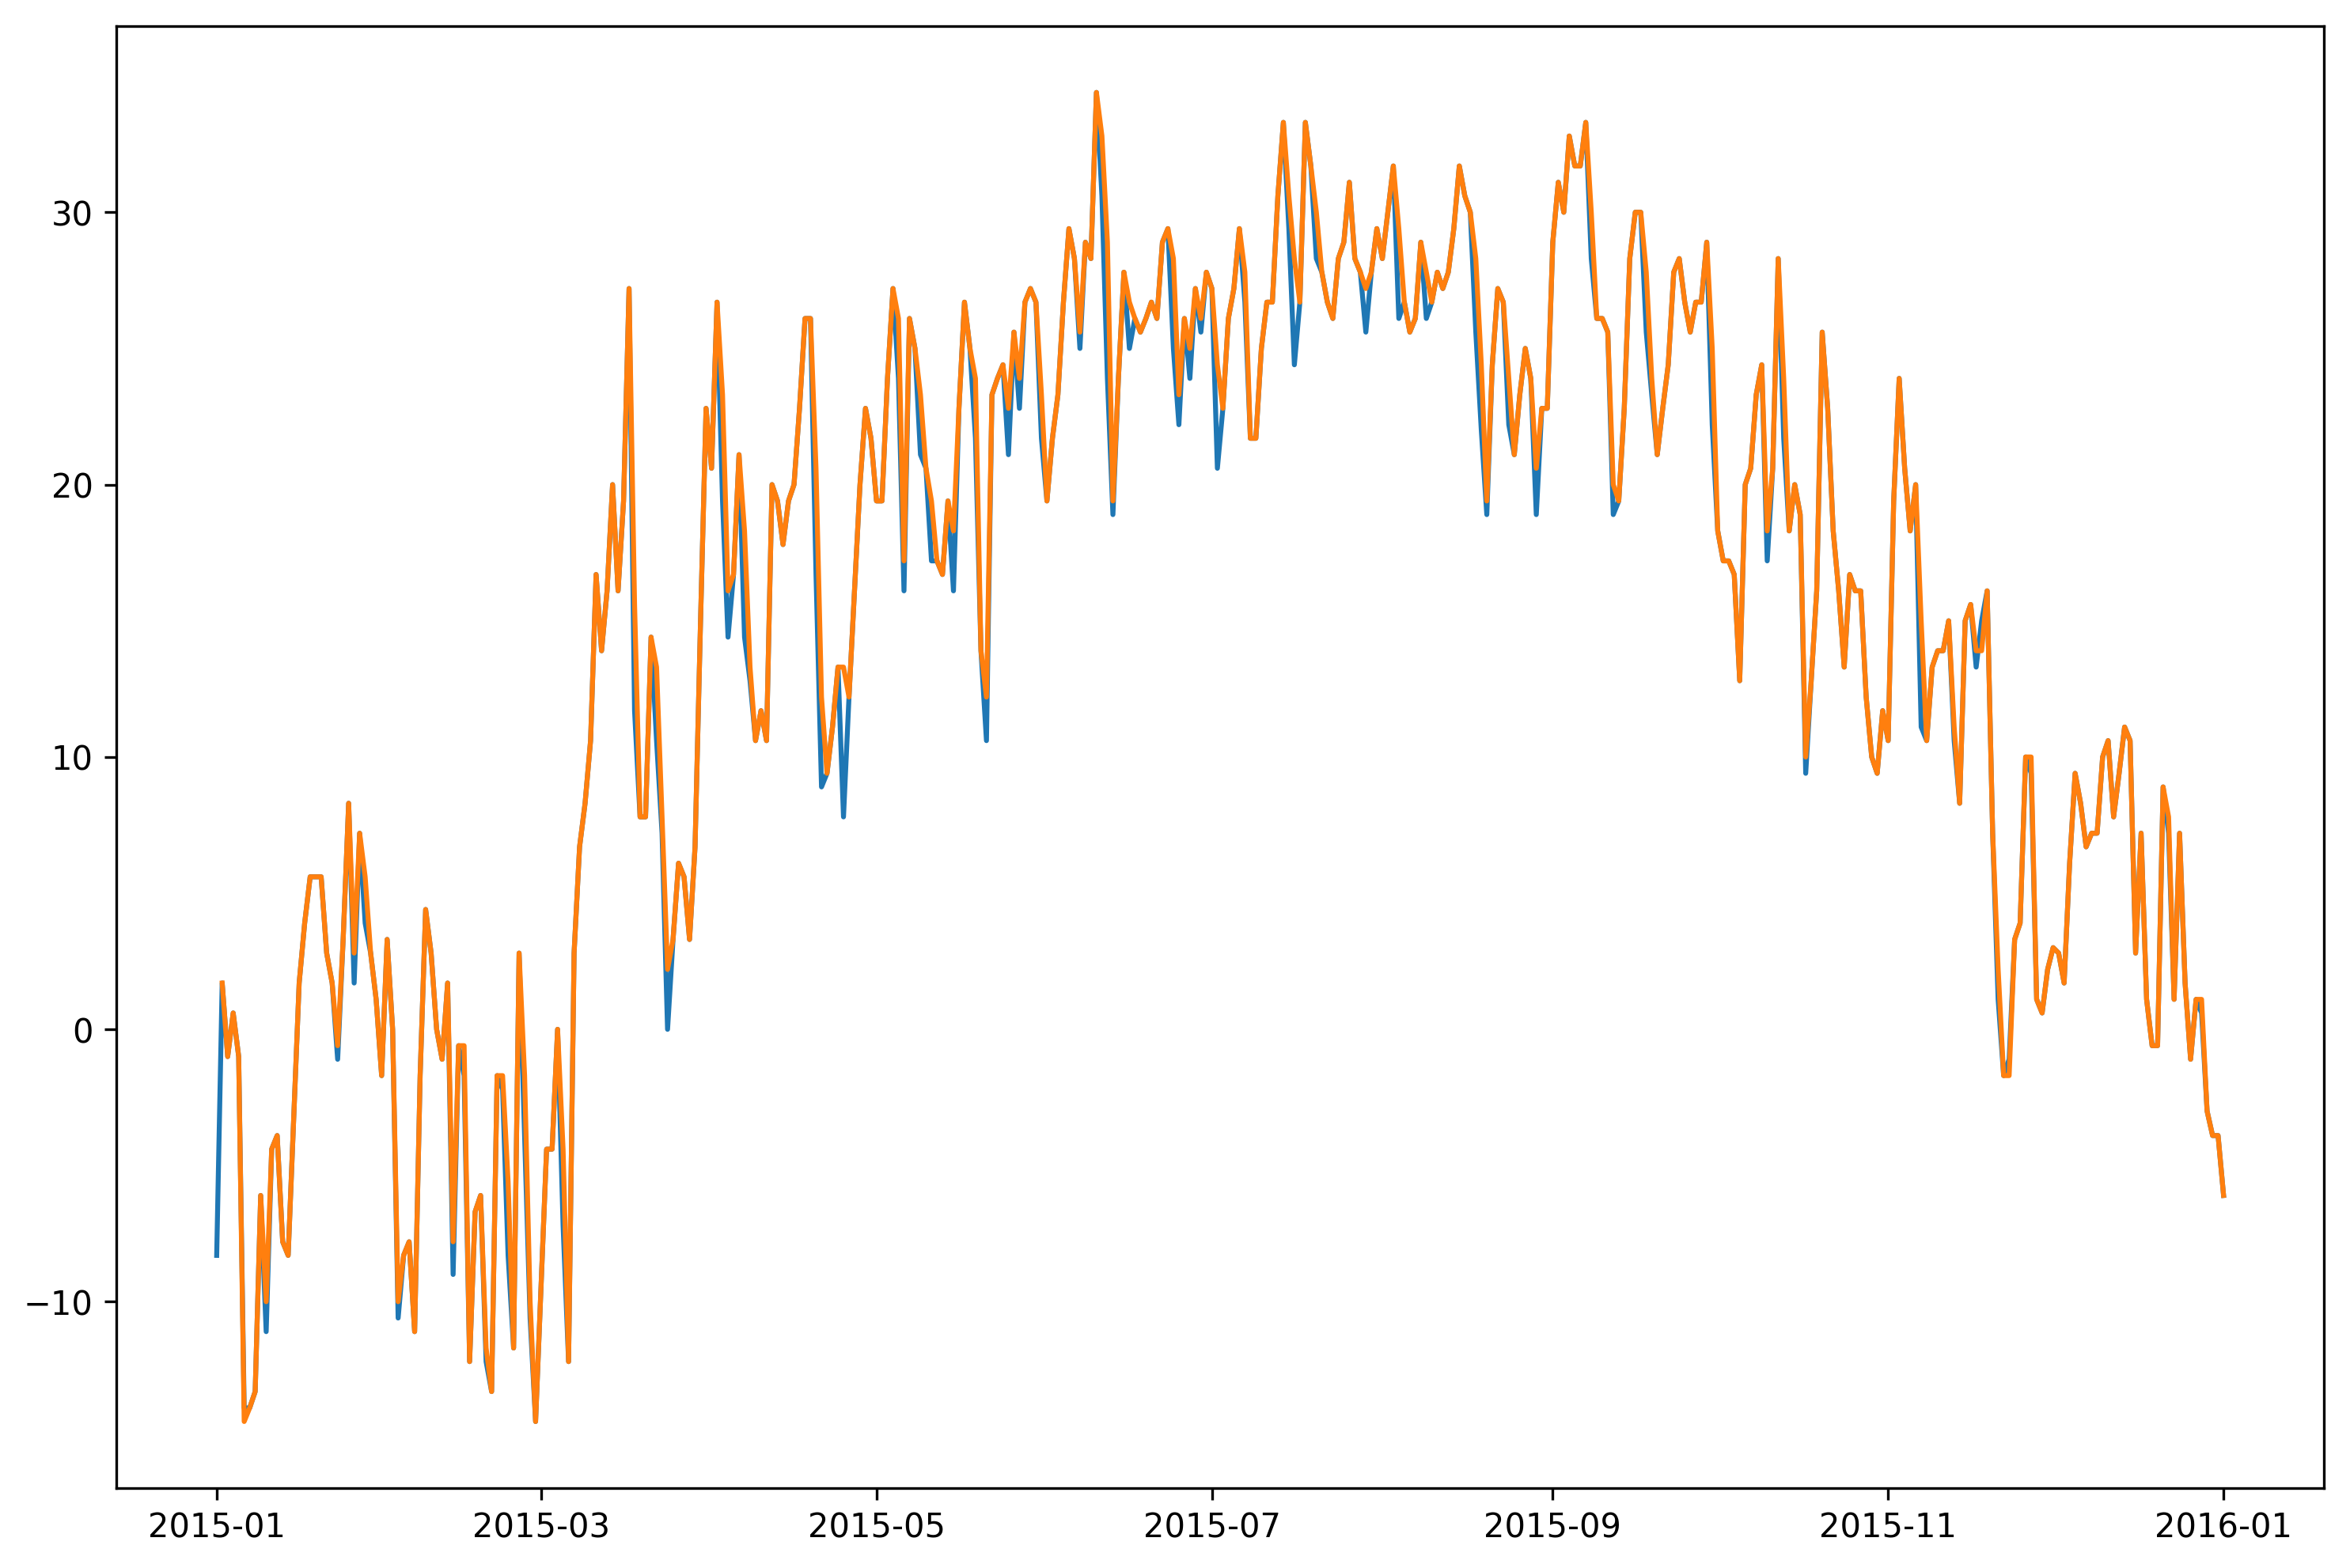

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x159088350>

In [189]:
plt.plot(TnTx_0[:day], TnTx_0[:Tx])
plt.plot(TnTx_23[:day]+Day(1), TnTx_23[:Tx])
# plt.xlim(Date(2015,4,20), Date(2015,5,3))

In [156]:
DataFrames.tail(get_TnTx(hourly_test[:temp].values,
              hourly_test[:ts].values,
              Hour(0)))

6×4 DataFrames.DataFrame
│ Row │ day        │ Tn    │ Tx   │ buffer                 │
├─────┼────────────┼───────┼──────┼────────────────────────┤
│ 1   │ 2015-12-27 │ -1.1  │ 1.1  │ 428400000 milliseconds │
│ 2   │ 2015-12-28 │ -6.1  │ 0.6  │ 342000000 milliseconds │
│ 3   │ 2015-12-29 │ -6.1  │ -3.0 │ 255600000 milliseconds │
│ 4   │ 2015-12-30 │ -6.0  │ -3.9 │ 169200000 milliseconds │
│ 5   │ 2015-12-31 │ -6.1  │ -3.9 │ 82800000 milliseconds  │
│ 6   │ 2016-01-01 │ -10.0 │ -6.1 │ 0 milliseconds         │

In [172]:
DataFrames.tail(get_TnTx(hourly_test[:temp].values,
              hourly_test[:ts].values,
              Hour(23)))

6×4 DataFrames.DataFrame
│ Row │ day        │ Tn    │ Tx   │ buffer                 │
├─────┼────────────┼───────┼──────┼────────────────────────┤
│ 1   │ 2015-12-26 │ -1.1  │ 1.1  │ 432000000 milliseconds │
│ 2   │ 2015-12-27 │ -5.0  │ 1.1  │ 345600000 milliseconds │
│ 3   │ 2015-12-28 │ -6.1  │ -3.0 │ 259200000 milliseconds │
│ 4   │ 2015-12-29 │ -6.0  │ -3.9 │ 172800000 milliseconds │
│ 5   │ 2015-12-30 │ -6.1  │ -3.9 │ 86400000 milliseconds  │
│ 6   │ 2015-12-31 │ -10.0 │ -6.1 │ 0 milliseconds         │

In [165]:
ts[1:50]

50-element Array{DateTime,1}:
 2015-01-01T00:00:00
 2015-01-01T00:54:00
 2015-01-01T01:54:00
 2015-01-01T02:54:00
 2015-01-01T03:54:00
 2015-01-01T04:54:00
 2015-01-01T05:54:00
 2015-01-01T06:00:00
 2015-01-01T06:54:00
 2015-01-01T07:54:00
 2015-01-01T08:54:00
 2015-01-01T09:54:00
 2015-01-01T10:54:00
 ⋮                  
 2015-01-02T06:54:00
 2015-01-02T07:54:00
 2015-01-02T08:54:00
 2015-01-02T09:54:00
 2015-01-02T10:54:00
 2015-01-02T11:54:00
 2015-01-02T12:00:00
 2015-01-02T12:54:00
 2015-01-02T13:54:00
 2015-01-02T14:54:00
 2015-01-02T15:54:00
 2015-01-02T16:54:00

In [161]:
ts = hourly_test[:ts].values
ts[1]

2015-01-01T00:00:00

In [168]:
TempModel.measurement_date.(ts[1:50], Hour(1))

50-element Array{Date,1}:
 2015-01-01
 2015-01-01
 2015-01-01
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 2015-01-02
 ⋮         
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03
 2015-01-03

In [163]:
TempModel.measurement_date(ts[1], Hour(24))

2015-01-01

In [159]:
(15+9) / 365

0.06575342465753424

# Obtaining statistics

In [237]:
function get_window_summary(stacked_impute, ts, hr_measure)
    nstansamples = size(stacked_impute, 1)
    # For each Stan sample, extract the Tn and Tx
    # assuming the hour of measurement is `hour`
    measure_day = [TempModel.measurement_date(t, hr_measure) for t in ts]
    unique_days = sort(unique(measure_day))
    window_tntx_dfs = [get_TnTx(view(stacked_impute, iimpute, :), 
                                ts, measure_day, unique_days)
                       for iimpute in 1:nstansamples]

    # now for each day, extract some summary
    # statistics (over the samples)
    exampleTnTx = window_tntx_dfs[1]
    ndays = DataFrames.nrow(exampleTnTx)
    day_vec = exampleTnTx[:day]
    buffer_vec = exampleTnTx[:buffer]

    Tn_mean = zeros(ndays)
    Tx_mean = zeros(ndays)
    Tn_var = zeros(ndays)
    Tx_var = zeros(ndays)
    Tn_covar_yest = zeros(ndays)
    Tx_covar_yest = zeros(ndays)
    Tn_covar_tmrw = zeros(ndays)
    Tx_covar_tmrw = zeros(ndays)
    
    yesterday_Tns = zeros(nstansamples)
    yesterday_Txs = zeros(nstansamples)
    tomorrow_Tns = [TnTx[1,:Tn] for TnTx in window_tntx_dfs]
    tomorrow_Txs =[TnTx[1,:Tx] for TnTx in window_tntx_dfs]
    for iday in 1:ndays
        today_Tns = tomorrow_Tns
        today_Txs = tomorrow_Txs
        
        if iday < ndays
            tomorrow_Tns = [TnTx[iday+1,:Tn] for TnTx in window_tntx_dfs]
            tomorrow_Txs = [TnTx[iday+1,:Tx] for TnTx in window_tntx_dfs]
        else
            tomorrow_Tns = zeros(nstansamples)
            tomorrow_Txs = zeros(nstansamples)
        end
        
        Tn_mean[iday] = mean(today_Tns)
        Tx_mean[iday] = mean(today_Txs)
        Tn_var[iday] = var(today_Tns; corrected=false)
        Tx_var[iday] = var(today_Txs; corrected=false)
        Tn_covar_yest[iday] = cov(today_Tns, yesterday_Tns)
        Tn_covar_tmrw[iday] = cov(today_Tns, tomorrow_Tns)
        Tx_covar_yest[iday] = cov(today_Txs, yesterday_Txs)
        Tx_covar_tmrw[iday] = cov(today_Txs, tomorrow_Txs)
        
        yesterday_Tns = today_Tns
        yesterday_Txs = today_Txs
    end

    # and package it up into a DataFrame
    window_summary_df = DataFrames.DataFrame(
        Tn_mean = Tn_mean,
        Tx_mean = Tx_mean,
        Tn_var = Tn_var,
        Tx_var = Tx_var,
        Tn_covar_yest = Tn_covar_yest,
        Tx_covar_yest = Tx_covar_yest,
        Tn_covar_tmrw = Tn_covar_tmrw,
        Tx_covar_tmrw = Tx_covar_tmrw,
        day = day_vec,
        buffer = buffer_vec,
        )
    return window_summary_df
end

get_window_summary (generic function with 1 method)

## iterating over all hours and windows

In [ ]:
GPmodel = "nomodel"
models_hours_tntx_dict = Dict{String,
                              Dict{Hour, 
                                   Vector{DataFrames.DataFrame}
                                   }
                              }()
models = ["SExSE", "simpler", "sumprod"]

In [306]:
models = ["SExSE", "simpler", "sumprod"]

3-element Array{String,1}:
 "SExSE"  
 "simpler"
 "sumprod"

In [305]:
@time begin
    for GPmodel in models
        println("")
        println("==========")
        println(GPmodel)
        println("==========")
        hours_tntx_dict = Dict{Hour, 
                               Vector{DataFrames.DataFrame}
                               }()
        models_hours_tntx_dict[GPmodel] = hours_tntx_dict
        # initialize
        for hour in hours
            hours_tntx_dict[hour] = Vector{DataFrames.DataFrame}()
        end

        for window_num in 1:150
            println(window_num)
            # fitting window for Stan
            stan_fw = get_window(window_num)
            # center of the stan window
            center_fw = window_center(stan_fw, stan_increment)
            local chains
            local ts
            try
                # obtain Stan output samples
                chains, ts = get_chains_and_ts(stan_fw, GPmodel)
            catch
                break
            end
            # extract imputed temperatures
            temp_impute = get_temperatures_reparam(chains)
            stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
            nstansamples = size(stacked_impute, 1)
            for hour in hours
                print(hour)
                print(" --- ")
                window_summary_df = get_window_summary(stacked_impute, ts, hour)
                push!(hours_tntx_dict[hour], window_summary_df)
            end
        end
    end
end


sumprod
1
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 2
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 3
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 4
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours -

0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 28
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 29
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 30
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hou

0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 54
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 55
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 56
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hou

0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 80
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 81
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 82
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hou

0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 106
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 107
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 hours --- 8 hours --- 9 hours --- 10 hours --- 11 hours --- 12 hours --- 13 hours --- 14 hours --- 15 hours --- 16 hours --- 17 hours --- 18 hours --- 19 hours --- 20 hours --- 21 hours --- 22 hours --- 23 hours --- 108
0 hours --- 1 hour --- 2 hours --- 3 hours --- 4 hours --- 5 hours --- 6 hours --- 7 

Previous run: `2160.011339 seconds (5.84 G allocations: 1.282 TiB, 33.77% gc time)`

# Picking best window

In [307]:
all_hours_tntx_best = Dict{String,
                           Dict{Hour, 
                                DataFrames.DataFrame}
                           }()
for GPmodel in models
    all_hours_tntx_best[GPmodel] = Dict{
            Hour, DataFrames.DataFrame}()
    hours_tntx_dict = models_hours_tntx_dict[GPmodel]
    for hour in hours
        # make a single dataframe with all the 
        # fitting windows for this hour
        hour_tntx_cat = vcat(hours_tntx_dict[hour])
        # some days are covered by multiple windows
        # only keep the window with the longest buffer
        hour_tntx_best = DataFrames.by(hour_tntx_cat, 
                                       :day, 
                                       df -> df[indmax(df[:buffer]),:])
        all_hours_tntx_best[GPmodel][hour] = hour_tntx_best
    end
end

# Adding variance and covariances

In [251]:
function add_varcovar!(df::DataFrames.DataFrame, tntx::Symbol)
    tx_var = df[Symbol(tntx, "_var")]
    tx_covar_yest = df[Symbol(tntx, "_covar_yest")]
    tx_covar_tmrw = df[Symbol(tntx, "_covar_tmrw")]
    tx_varcovar = tx_var .+ tx_covar_yest .+ tx_covar_tmrw
    df[Symbol(tntx, "_varcovar")] = tx_varcovar
    return df
end 

add_varcovar! (generic function with 1 method)

In [308]:
for GPmodel in models
    for hour in hours
        add_varcovar!(all_hours_tntx_best[GPmodel][hour], :Tx)
        add_varcovar!(all_hours_tntx_best[GPmodel][hour], :Tn)
    end
end

# Comparing imputed & true Tn & Tx

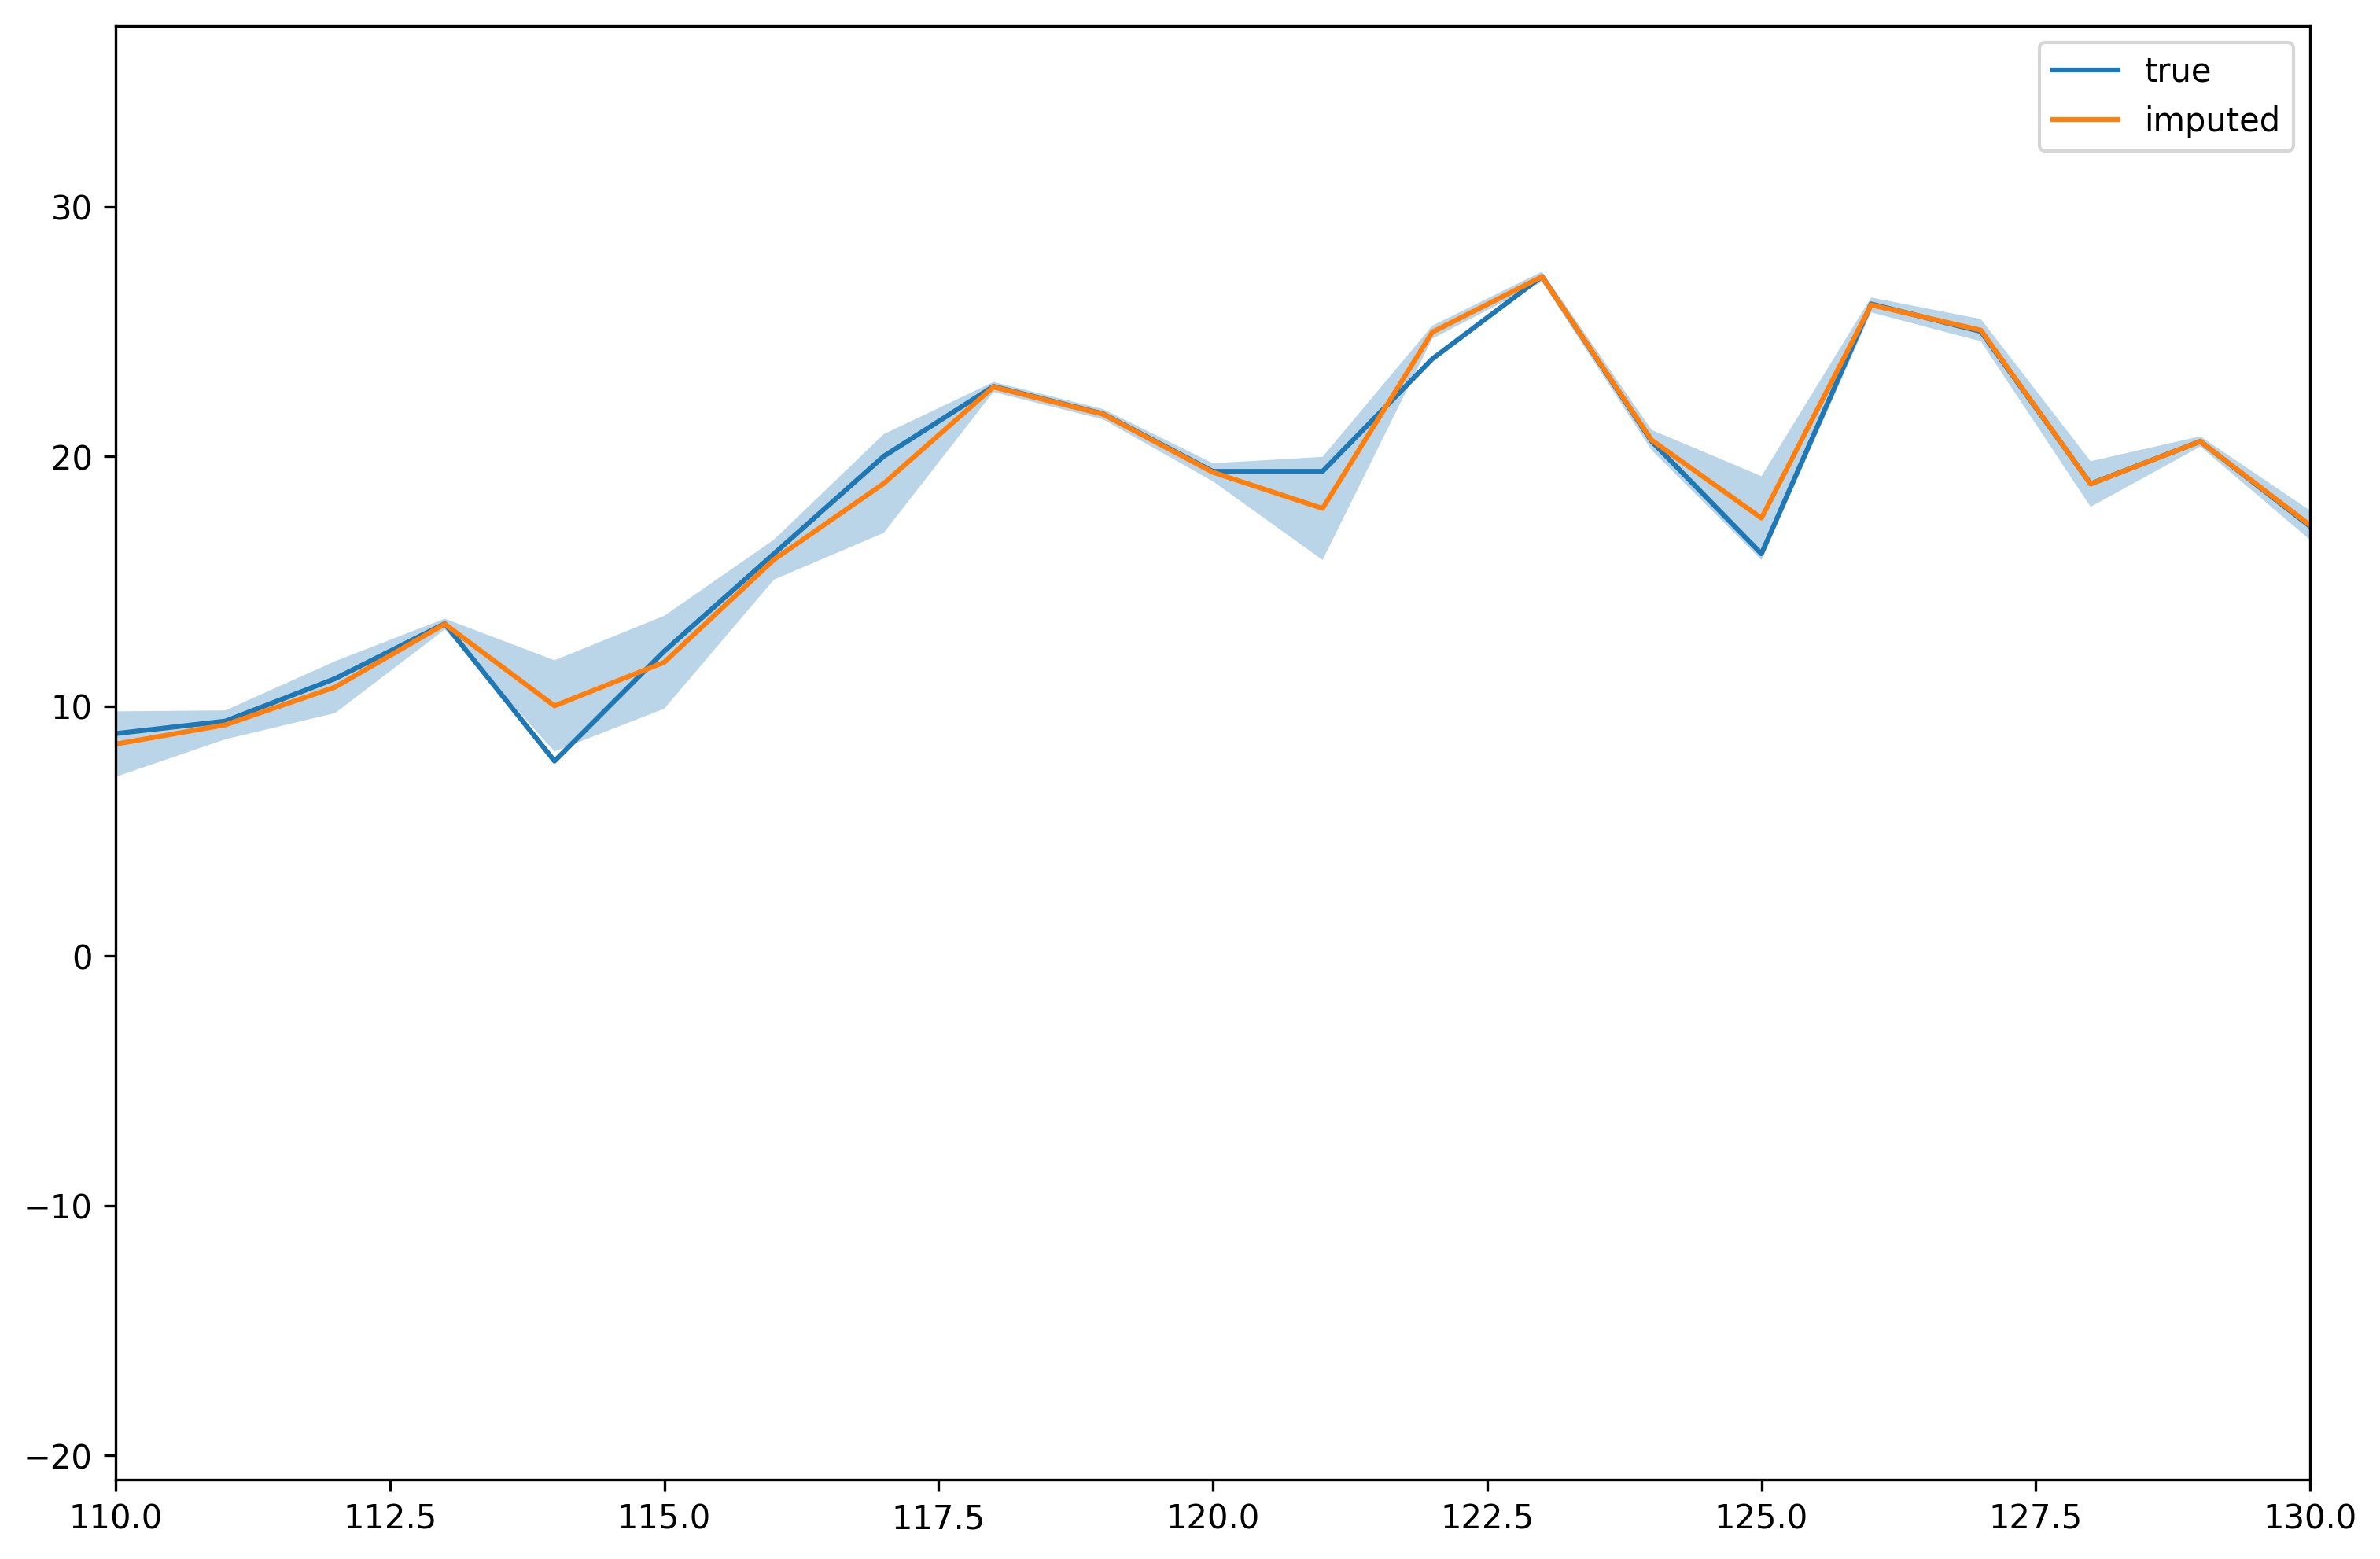

366

(110, 130)

In [257]:
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    plt.plot(TnTx[:Tx], label="true")
    tntx_impt = all_hours_tntx_best[GPmodel][hr]
    y = tntx_impt[:Tx_mean]
    y_err = sqrt.(tntx_impt[:Tx_var])
    plt.plot(y, label="imputed")
    x = 0:length(y)-1
    plt.fill_between(x, y.-2*y_err, y.+2*y_err, alpha=0.3)
    plt.legend(loc="best")
end
plt.xlim(110,130)

In [106]:
include("src/plot_diagnostics.jl")

plot_residuals (generic function with 1 method)

In [115]:
window_num = 37
stan_fw = get_window(window_num)

FittingWindow(2015-04-19, 2015-04-28)

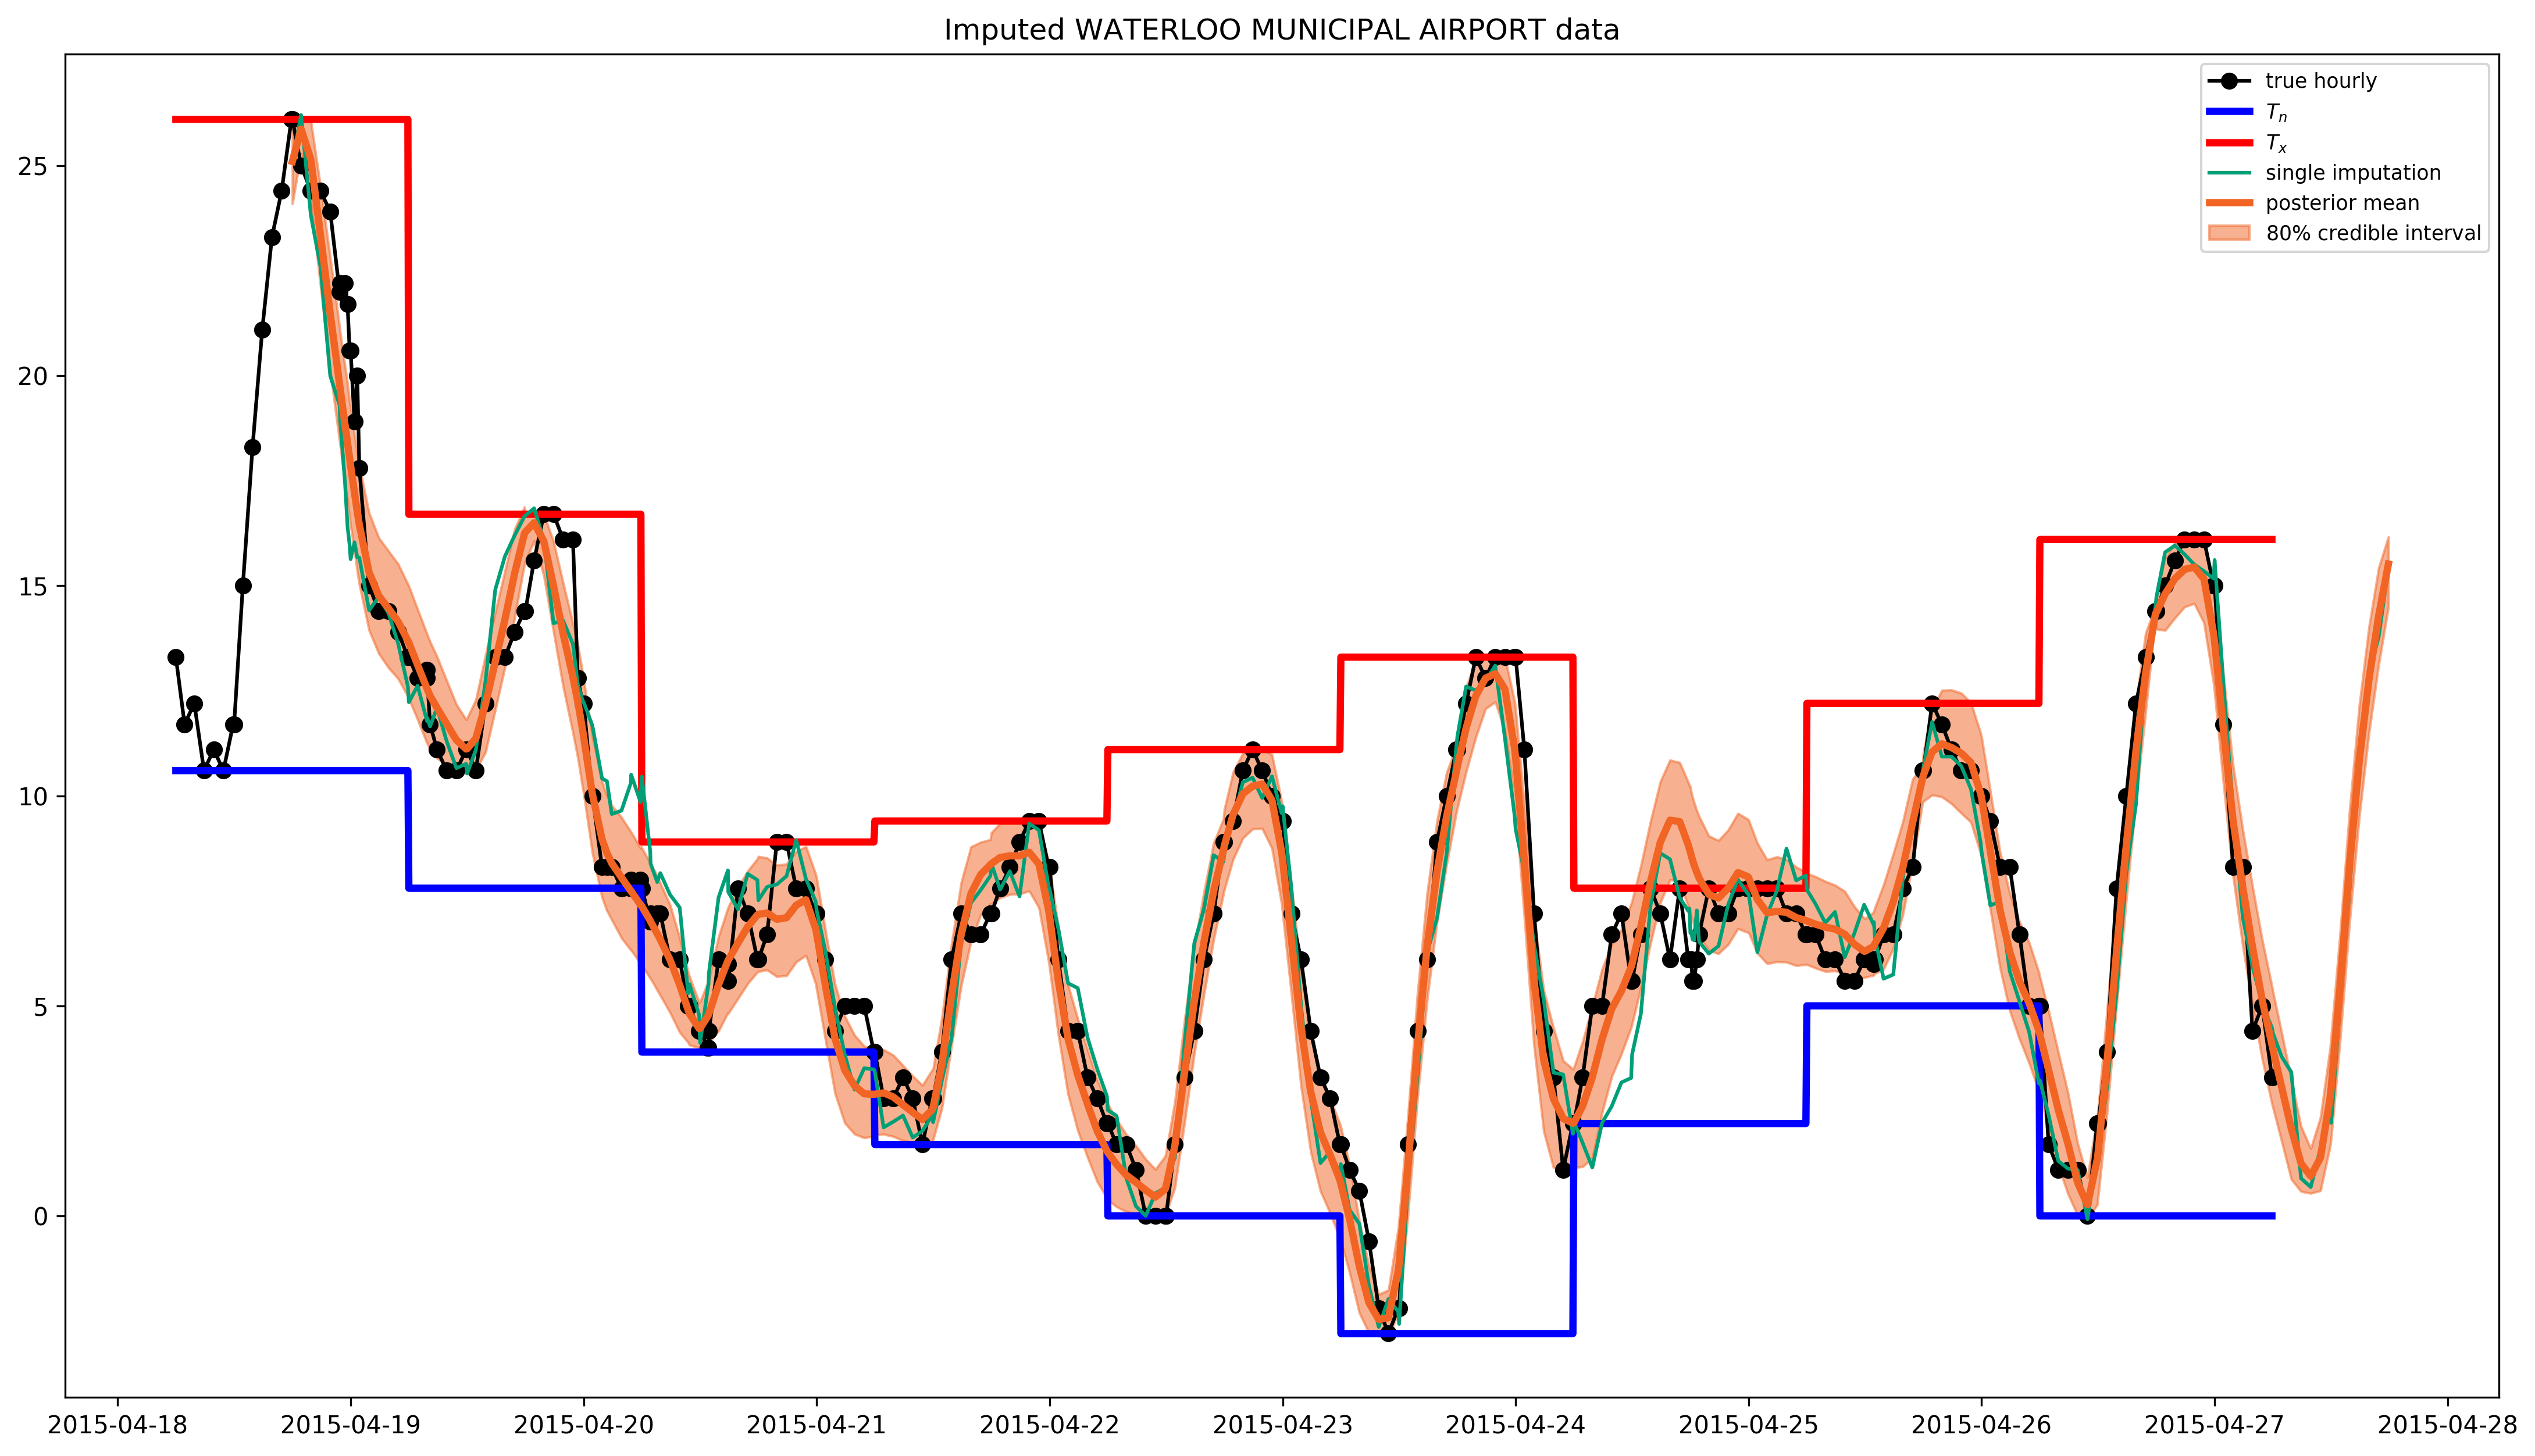

In [309]:
begin
    hr_measure = Hour(5) # number between 0 and 24
    hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
    
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    TnTx = get_TnTx(temps, ts, hr_measure)
    
    TnTx = DataTables.by(hourly_test, :ts_day, df -> DataTable(
        Tn=minimum(df[:temp].values), 
        Tx=maximum(df[:temp].values)))
    # add column to test data for TnTx (useful for plotting)
    test_trimmed=join(hourly_test, TnTx, on=:ts_day)

    GPmodel = "simpler"
    window_num = 37
    stan_fw = get_window(window_num)
    chains, chain_ts = get_chains_and_ts(stan_fw, GPmodel)
    temp_impute = get_temperatures_reparam(chains)
    test_subsubset = get_test_fw(test_trimmed, stan_fw)

    plot_truth(test_subsubset)
    plot_imputations(chain_ts, temp_impute)

    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
end
;

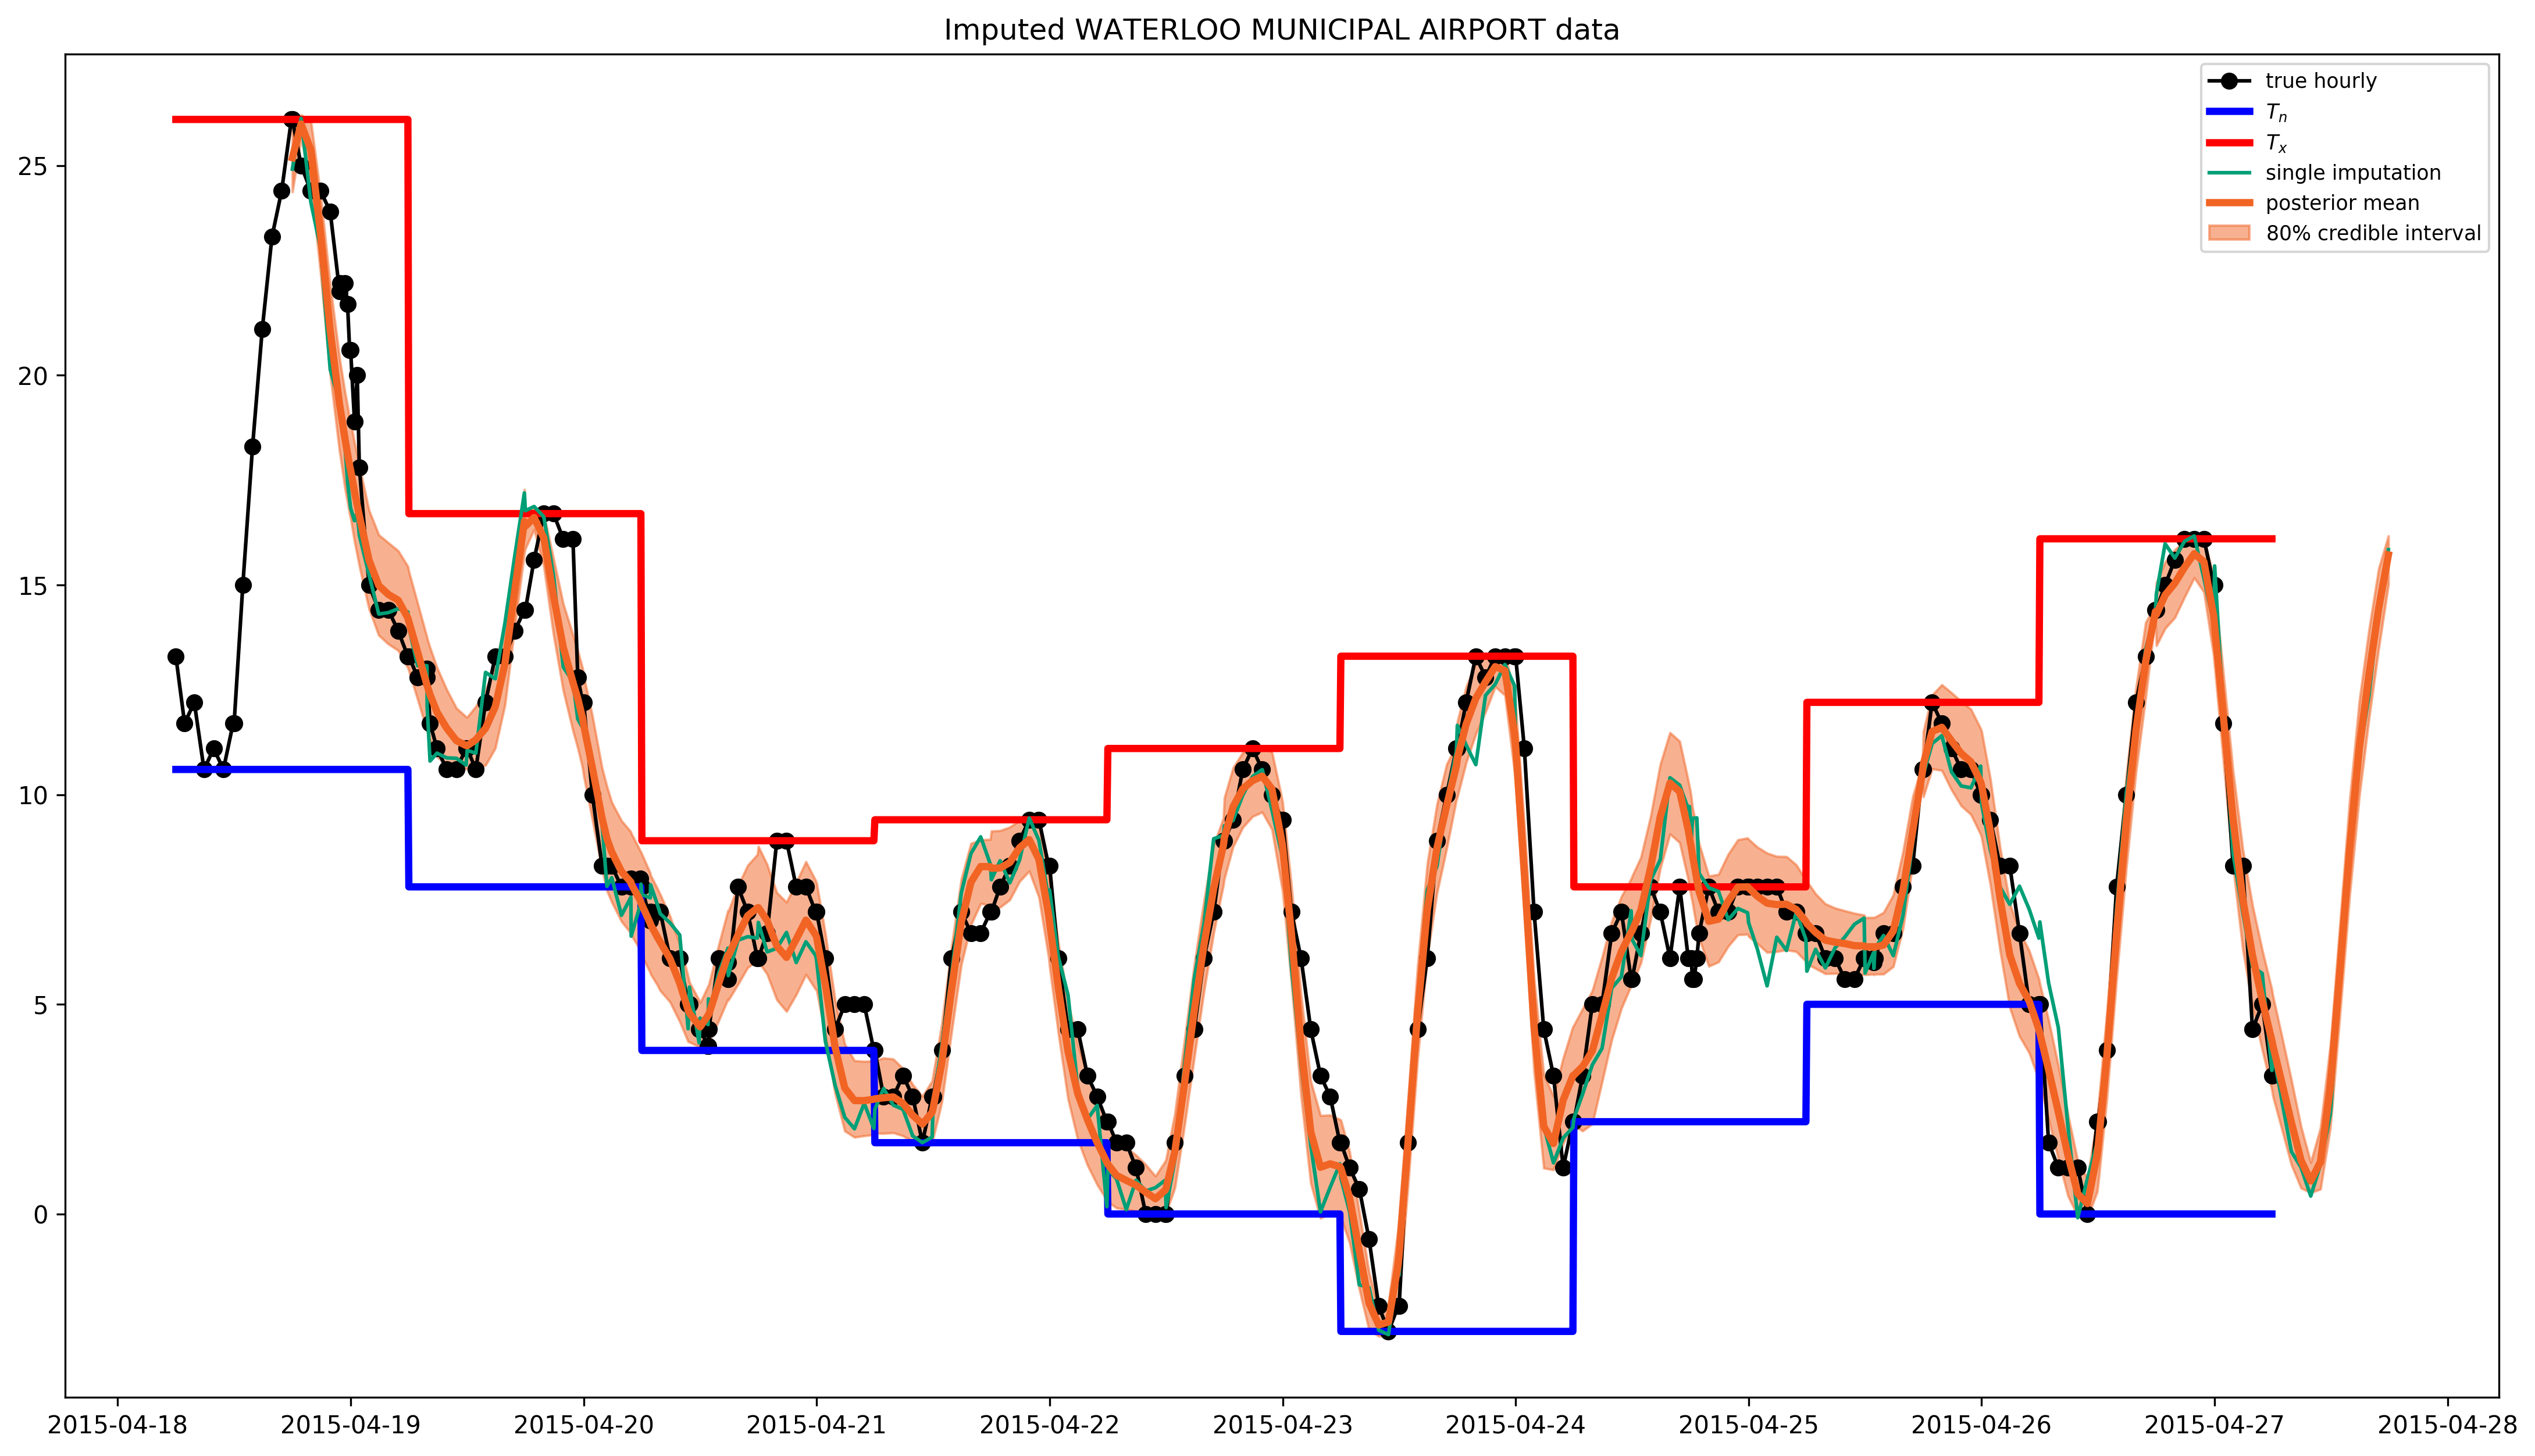

In [310]:
begin
    hr_measure = Hour(5) # number between 0 and 24
    hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
    
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    TnTx = get_TnTx(temps, ts, hr_measure)
    
    TnTx = DataTables.by(hourly_test, :ts_day, df -> DataTable(
        Tn=minimum(df[:temp].values), 
        Tx=maximum(df[:temp].values)))
    # add column to test data for TnTx (useful for plotting)
    test_trimmed=join(hourly_test, TnTx, on=:ts_day)

    GPmodel = "SExSE"
    window_num = 37
    stan_fw = get_window(window_num)
    chains, chain_ts = get_chains_and_ts(stan_fw, GPmodel)
    temp_impute = get_temperatures_reparam(chains)
    test_subsubset = get_test_fw(test_trimmed, stan_fw)

    plot_truth(test_subsubset)
    plot_imputations(chain_ts, temp_impute)

    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
end
;

In [101]:
TnTx[114,:]

1×4 DataFrames.DataFrame
│ Row │ day        │ Tn   │ Tx   │ buffer                  │
├─────┼────────────┼──────┼──────┼─────────────────────────┤
│ 1   │ 2015-04-24 │ -2.8 │ 13.3 │ 9698400000 milliseconds │

366(366,)
(364,)
366

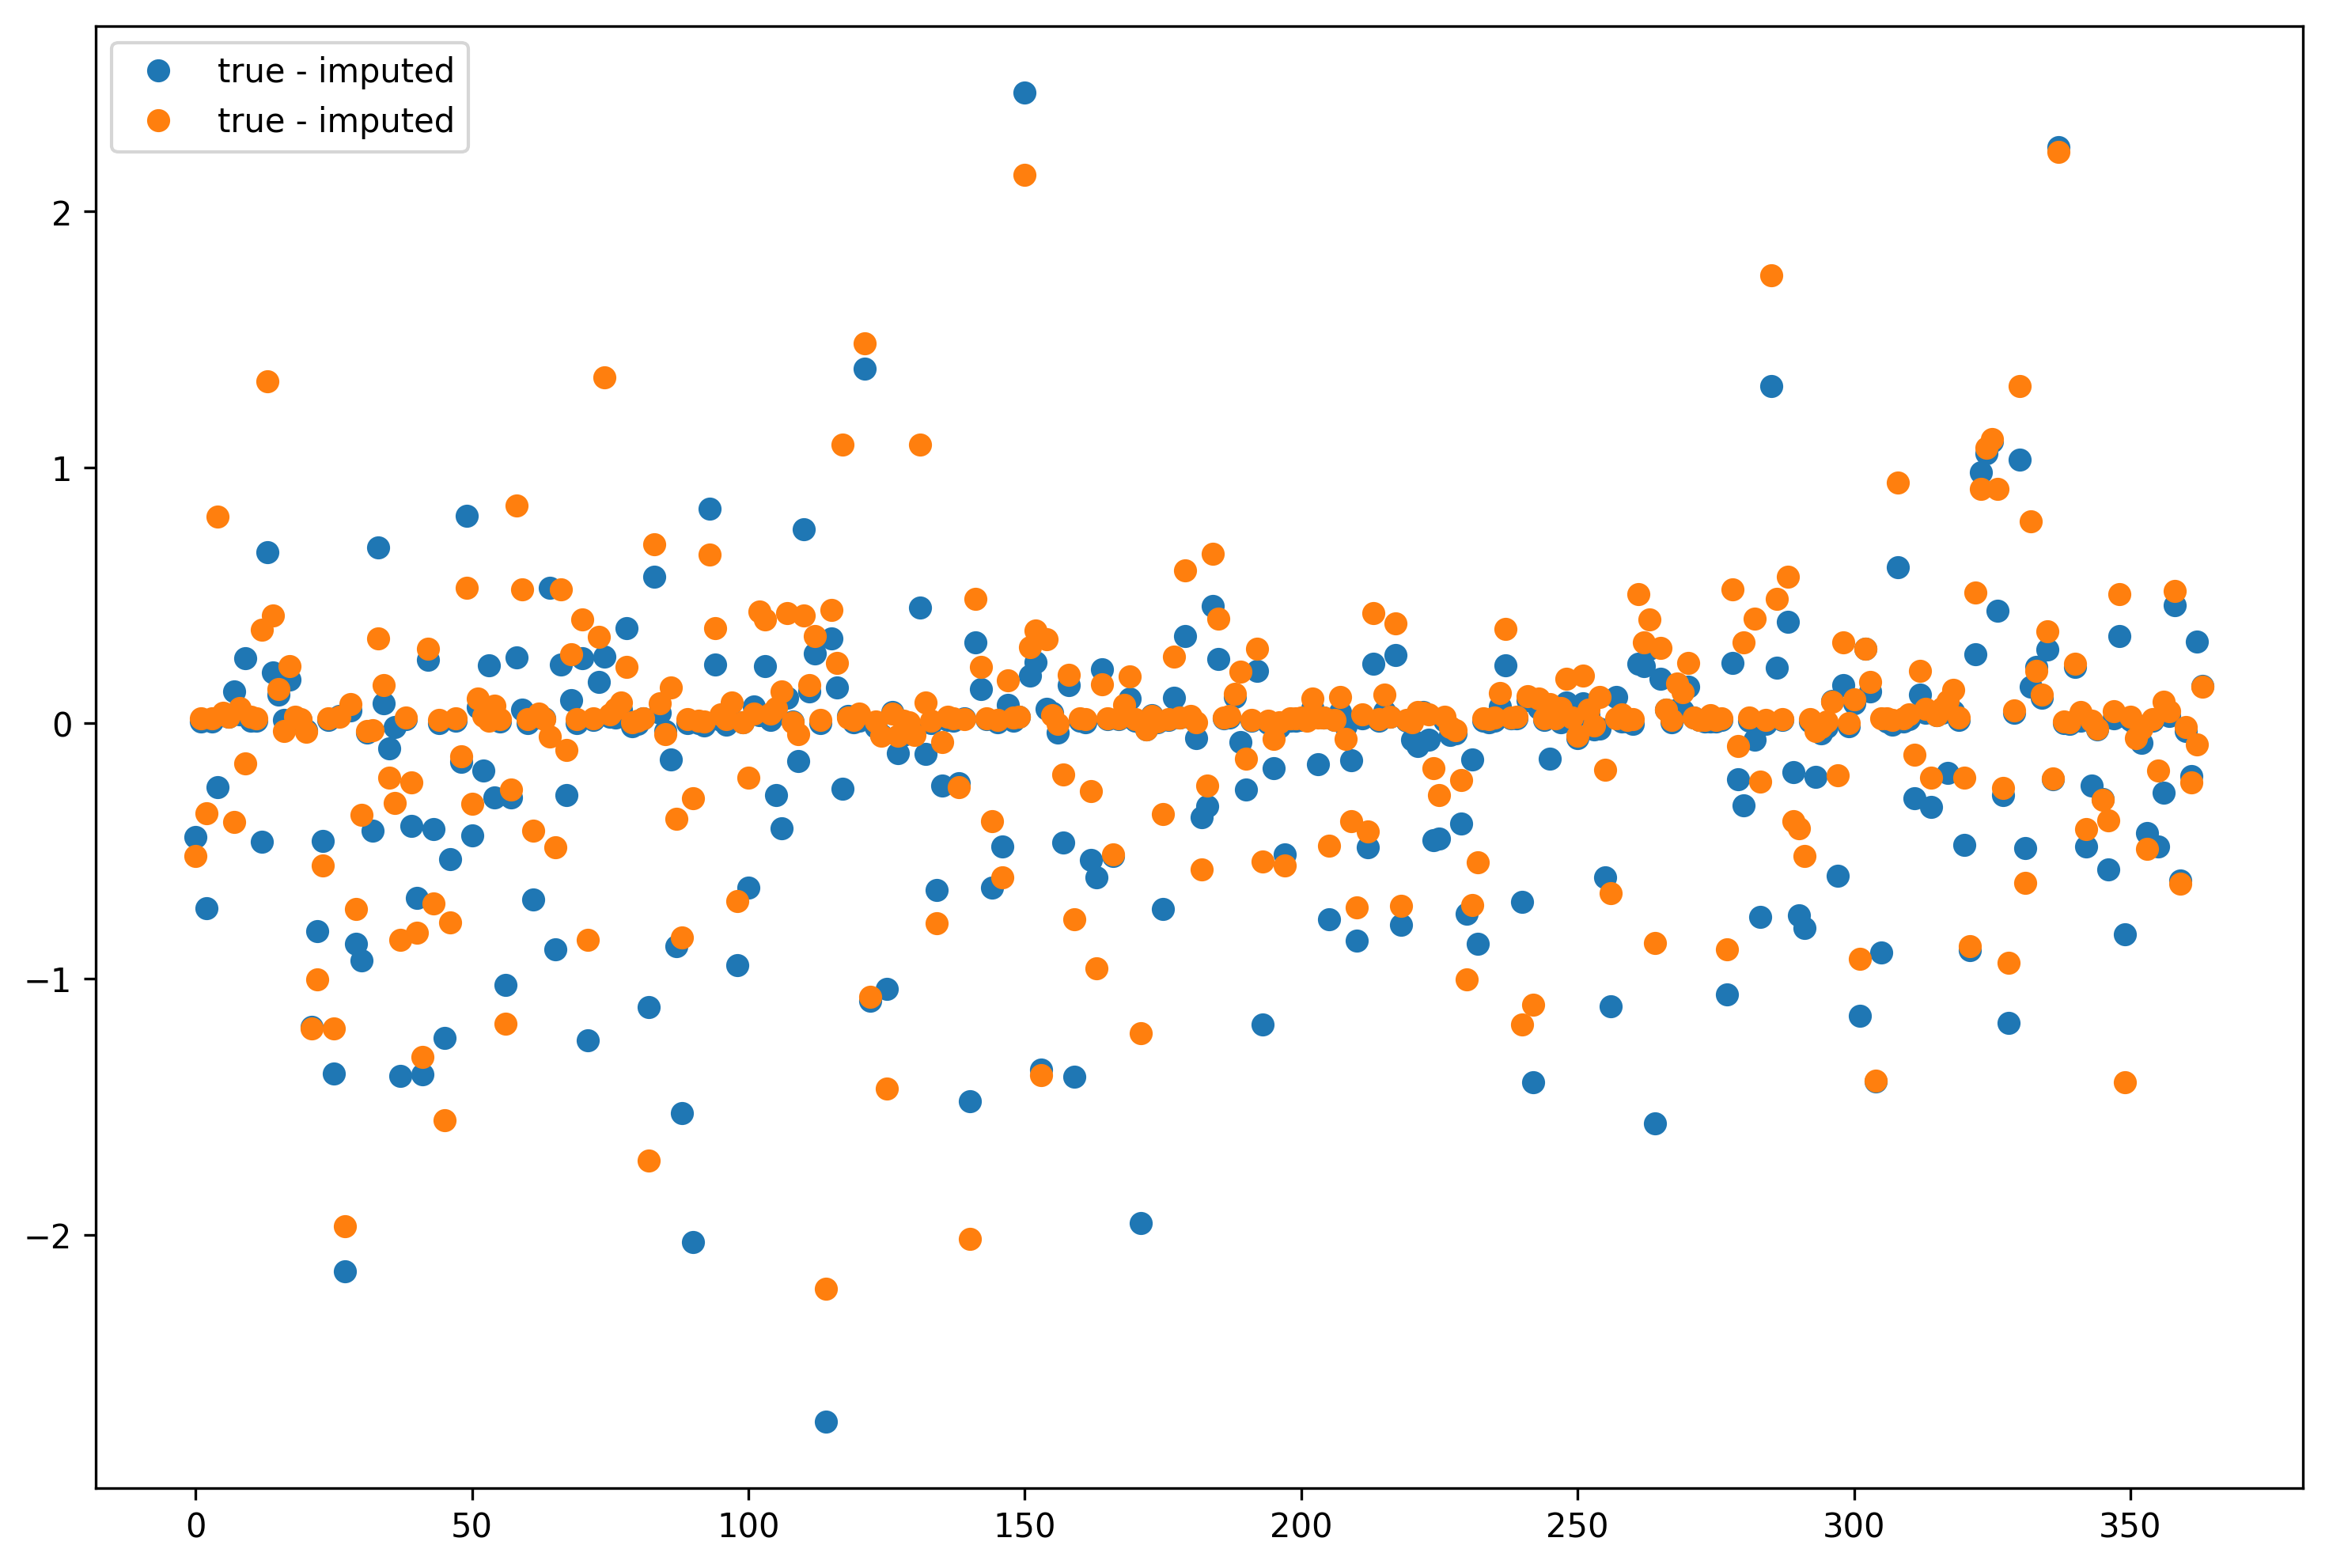

(366,)
(364,)


In [124]:
begin
    GPmodel = "SExSE"
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plot(y_diff, "o", label="true - imputed (SExSE)")
end
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plot(y_diff, "o", label="true - imputed (simpler)")
    plt.legend(loc="best")
end
;

366(366,)
(364,)
366

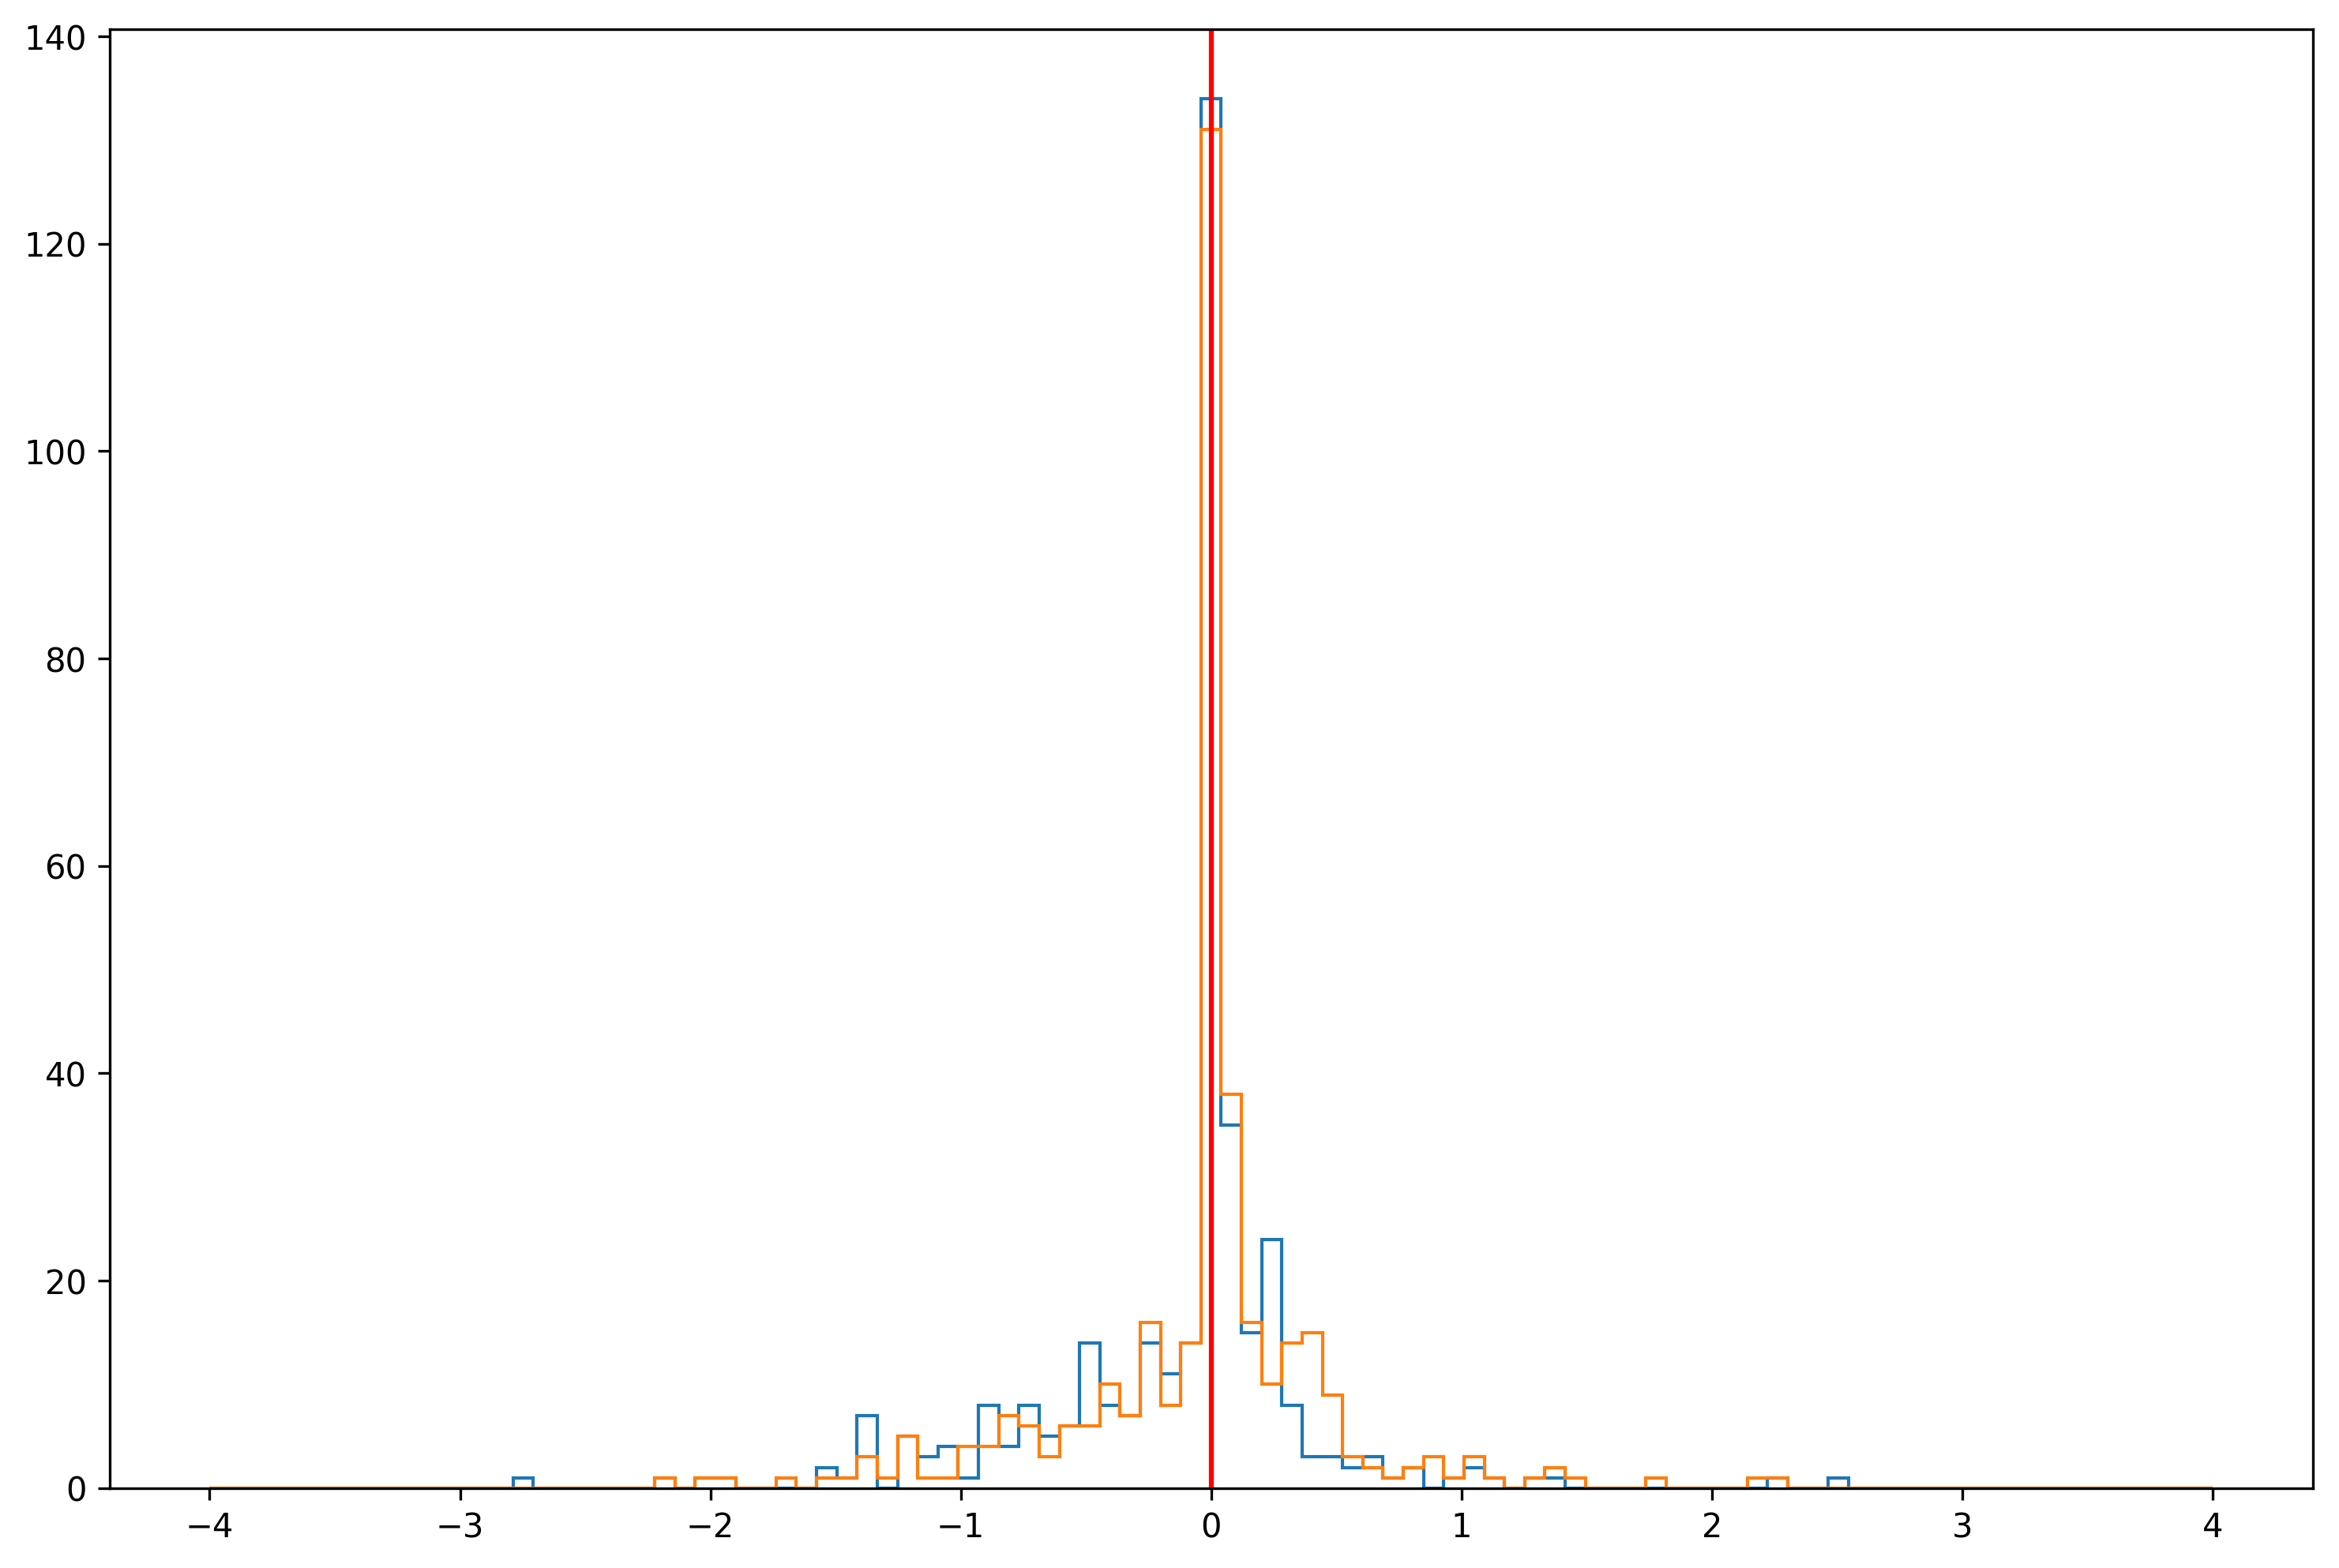

(366,)
(364,)


In [129]:
begin
    GPmodel = "SExSE"
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plt[:hist](y_diff, bins=linspace(-4,4,100), histtype="step")
end
begin
    GPmodel = "simpler"
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(5)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    temp_true = TnTx[:Tx]
    temp_impt = all_hours_tntx_best[GPmodel][hr][:Tx_mean]
    println(size(temp_true))
    println(size(temp_impt))
    y_diff = temp_true[1:length(temp_impt)] .- temp_impt
    plt.plt[:hist](y_diff, bins=linspace(-4,4,100), histtype="step")
end
plt.axvline(x=0.0, color="red")
plt.legend(loc="best")
# plt.xlim(-2,2)
;

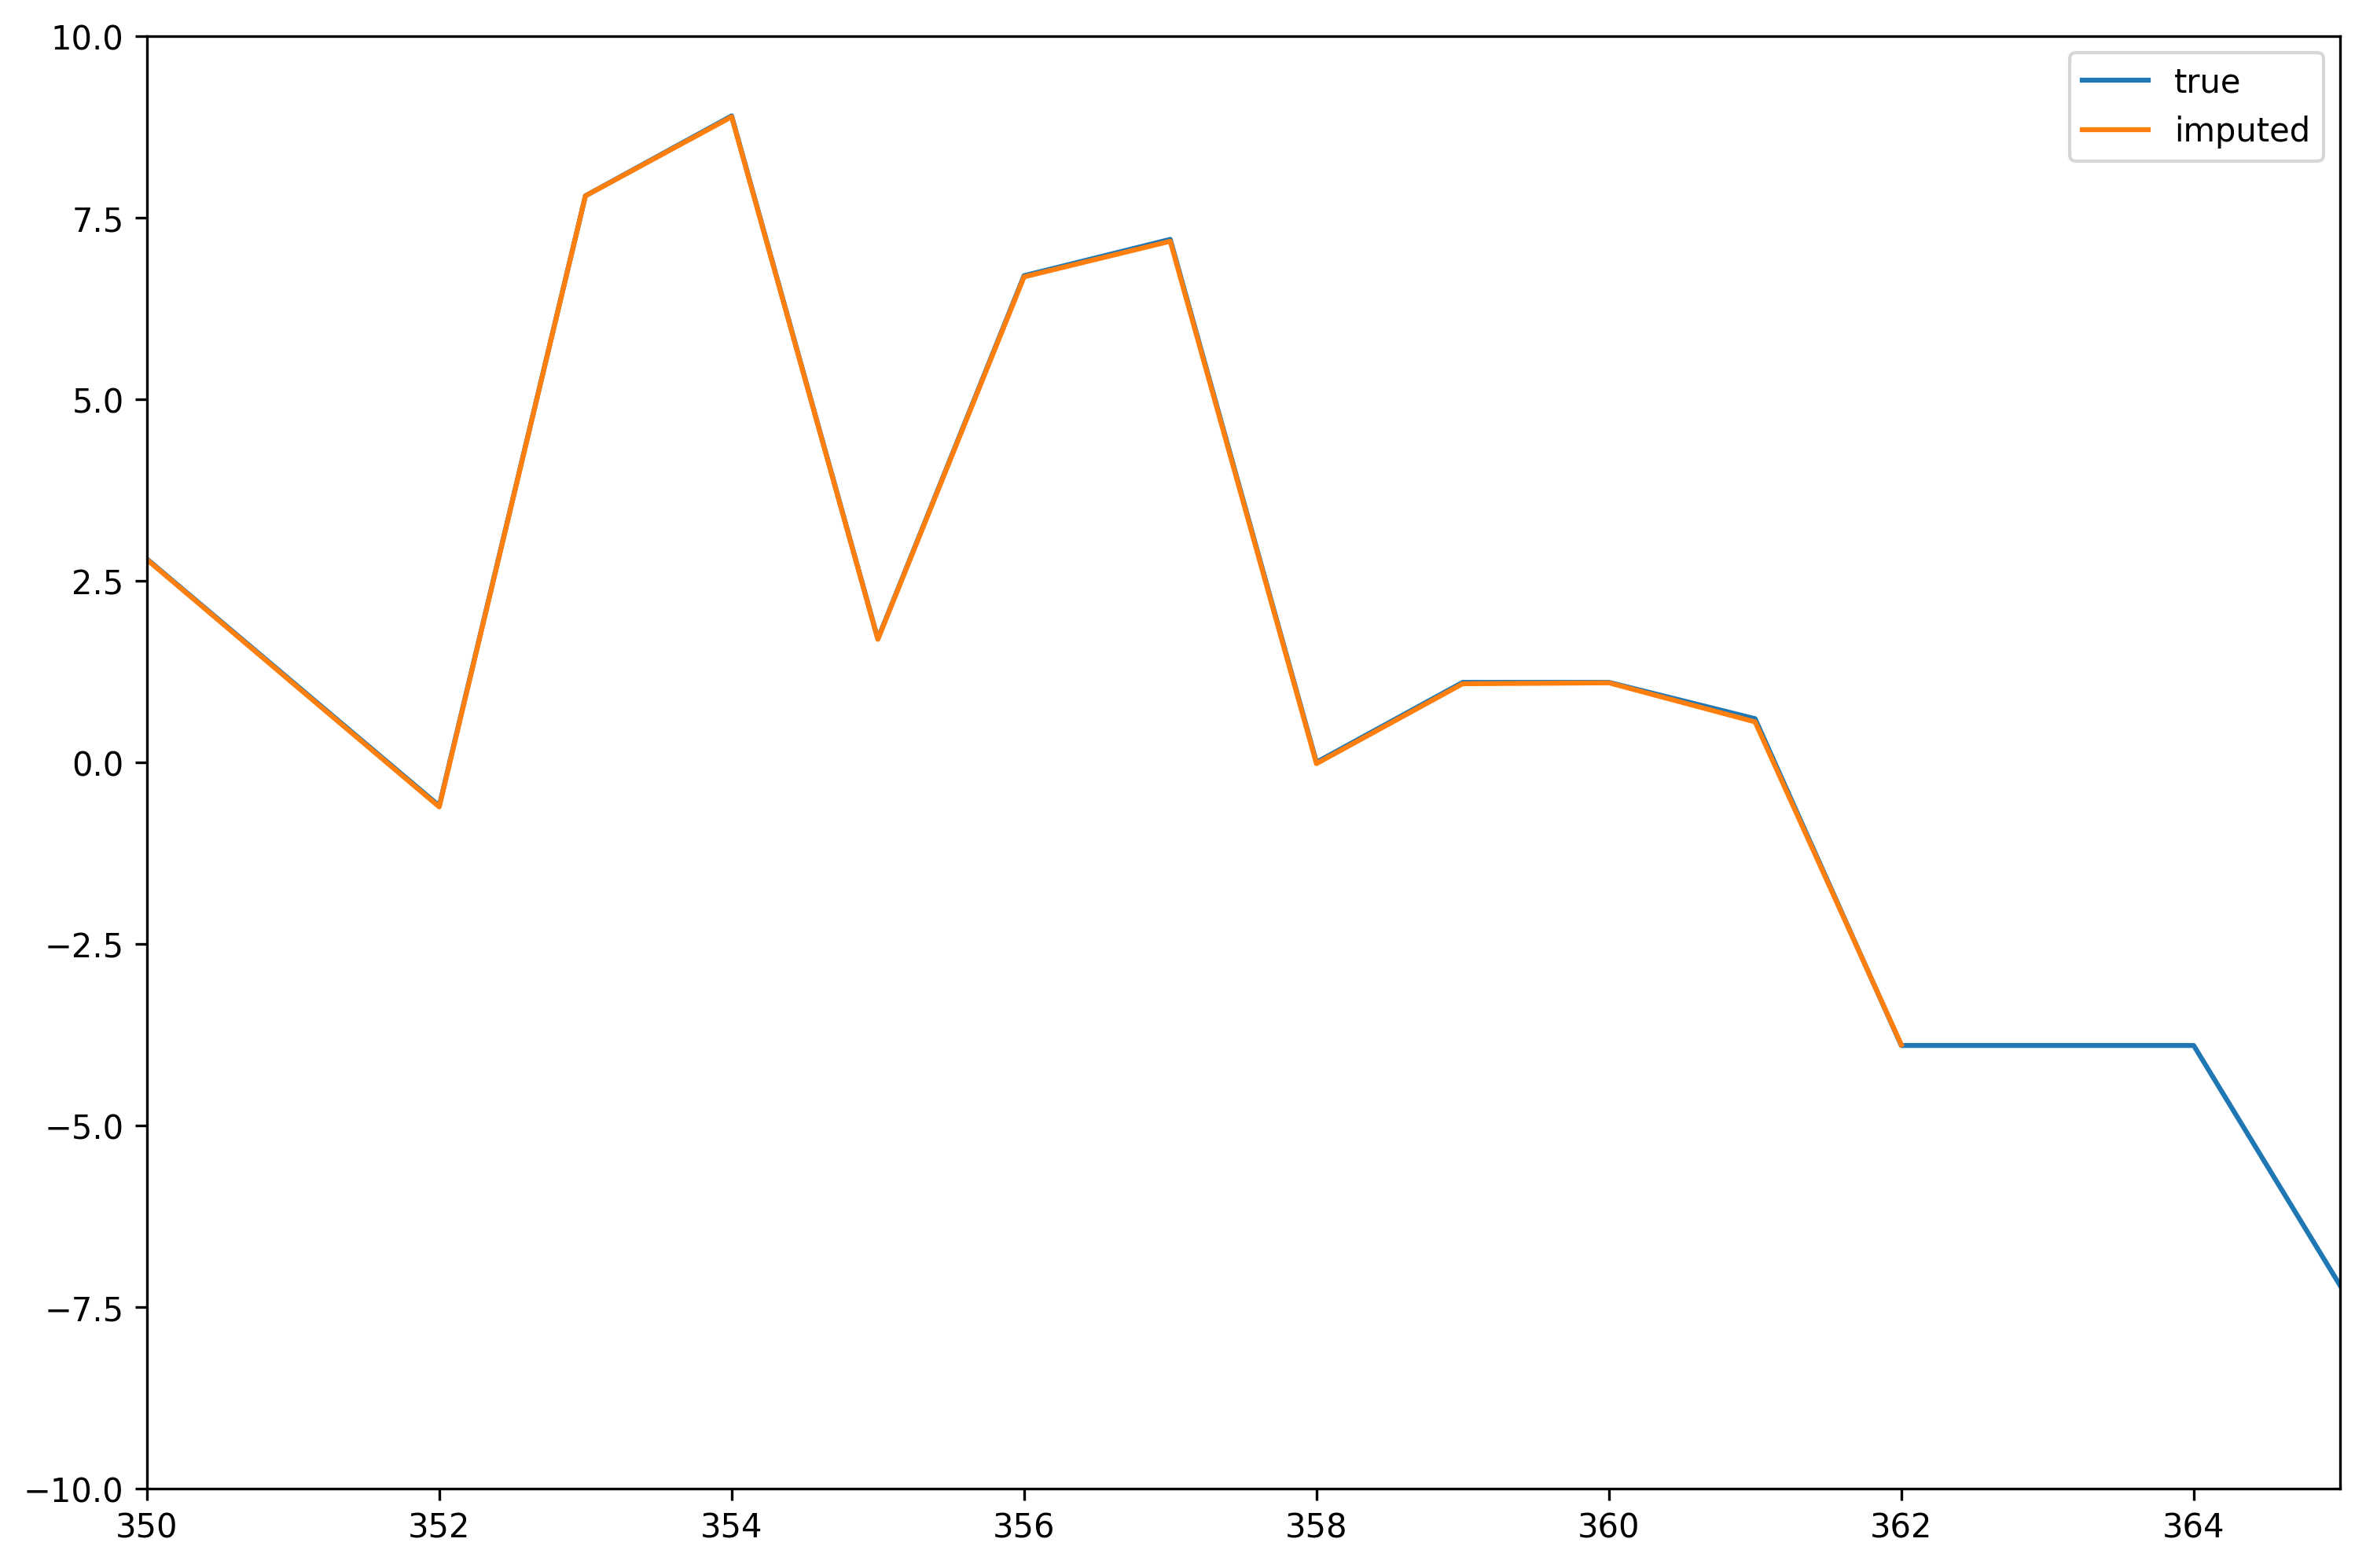

366

(-10, 10)

In [93]:
begin
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    hr = Hour(17)
    TnTx = get_TnTx(temps, ts, hr)
    print(DataFrames.nrow(TnTx))
    DataFrames.head(TnTx)
    plt.plot(TnTx[:Tx], label="true")
    plt.plot(all_hours_tntx_best[hr][:Tx_mean], label="imputed")
    plt.legend(loc="best")
end
plt.xlim(350,365)
plt.ylim(-10,10)

# Summarizing

In [48]:
function maxmindate(tntx_dict::Dict{Hour, DataFrames.DataFrame})
    maxmin = maximum(
        minimum(tntx[:day])
        for tntx in values(tntx_dict)
        )
    return maxmin
end
function minmaxdate(tntx_dict::Dict{Hour, DataFrames.DataFrame})
    minmax = minimum(
        maximum(tntx[:day])
        for tntx in values(tntx_dict)
        )
    return minmax
end
minday = maxmindate(all_hours_tntx_best)
maxday = minmaxdate(all_hours_tntx_best)

2015-12-29

In [51]:
function mean_days(tntx_df::DataFrames.DataFrame, tntx_sym::Symbol, minday::Date, maxday::Date)
    y = tntx_df[tntx_sym]
    day = tntx_df[:day]
    inside = (day .>= minday) .& (day .<= maxday)
    return mean(y[inside])
end
mean_days(all_hours_tntx_best[Hour(17)], :Tn_mean, minday, maxday)

4.548478629390402

In [286]:
function mean_se(all_hours_tntx_best, GPmodel::String, tntx::Symbol, minday::Date, maxday::Date)
    mean_mean = [mean_days(all_hours_tntx_best[GPmodel][hour],
                          Symbol(tntx, "_mean"),
                          minday, maxday)
                for hour in hours]
    ndays = (maxday - minday + Day(1)) / Day(1)
    se2_mean = [(mean_days(
        all_hours_tntx_best[GPmodel][hour],
        Symbol(:Tn, "_var"), minday, maxday)
        / ndays)
        for hour in hours]
    varcovar_mean = [(
            mean_days(all_hours_tntx_best[GPmodel][hour],
            :Tn_varcovar,
            minday, maxday)
            / ndays)
            for hour in hours]              
    return mean_mean, se2_mean, varcovar_mean
end

mean_se (generic function with 1 method)

# Plotting

## truth

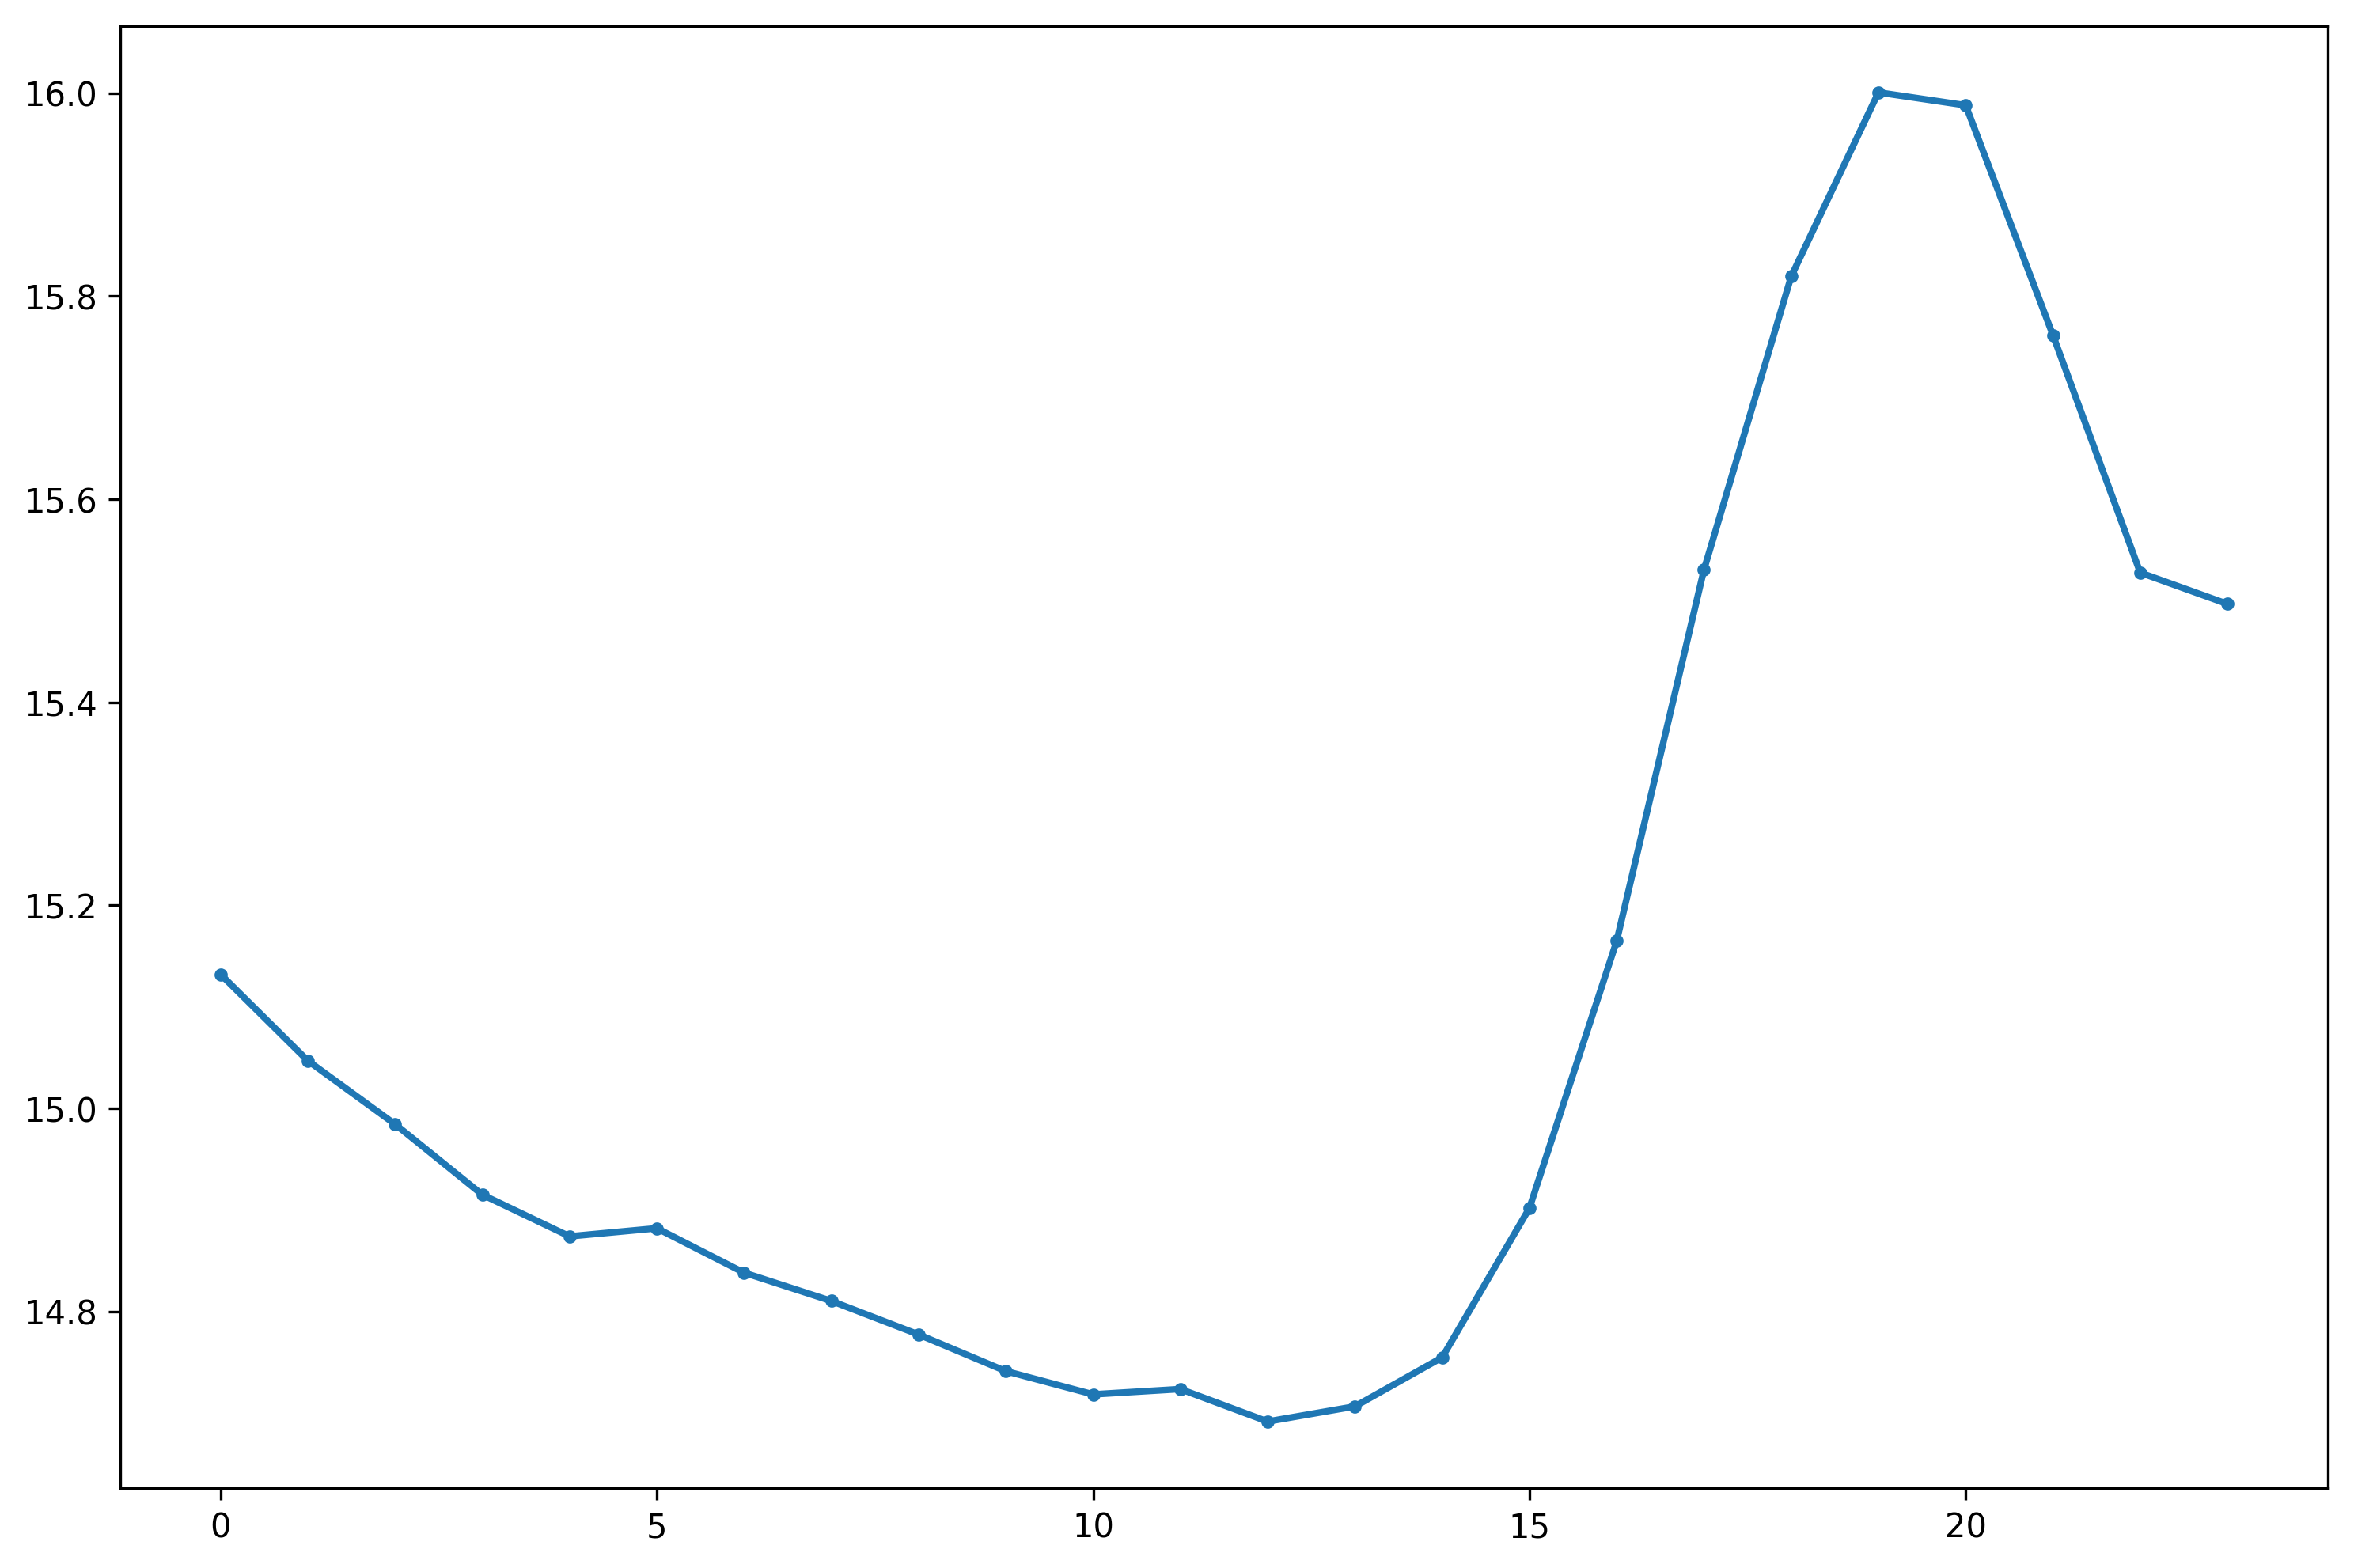

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1589a2ad0>

In [267]:
function plot_true_TnTx(tntx::Symbol, stat::Function, minday::Date, maxday::Date)
    stat_vec = Vector{Float64}()
    ts = hourly_test[:ts].values
    temps = hourly_test[:temp].values
    for hr in Hour(0):Hour(1):Hour(23)
        TnTx = get_TnTx(temps, ts, hr)
        day = TnTx[:day]
        inside = (day .>= minday) .& (day .<= maxday)
        push!(stat_vec, stat(TnTx[inside,tntx]))
    end
    plt.plot(0:23, stat_vec, 
             linewidth=2,
             marker=".",
             label="true")
end
plot_true_TnTx(:Tx, mean, minday, maxday)

## imputed

In [229]:
0.1 / sqrt(363)

0.00524863881081478

In [228]:
y_err[18]

0.005431685401373528

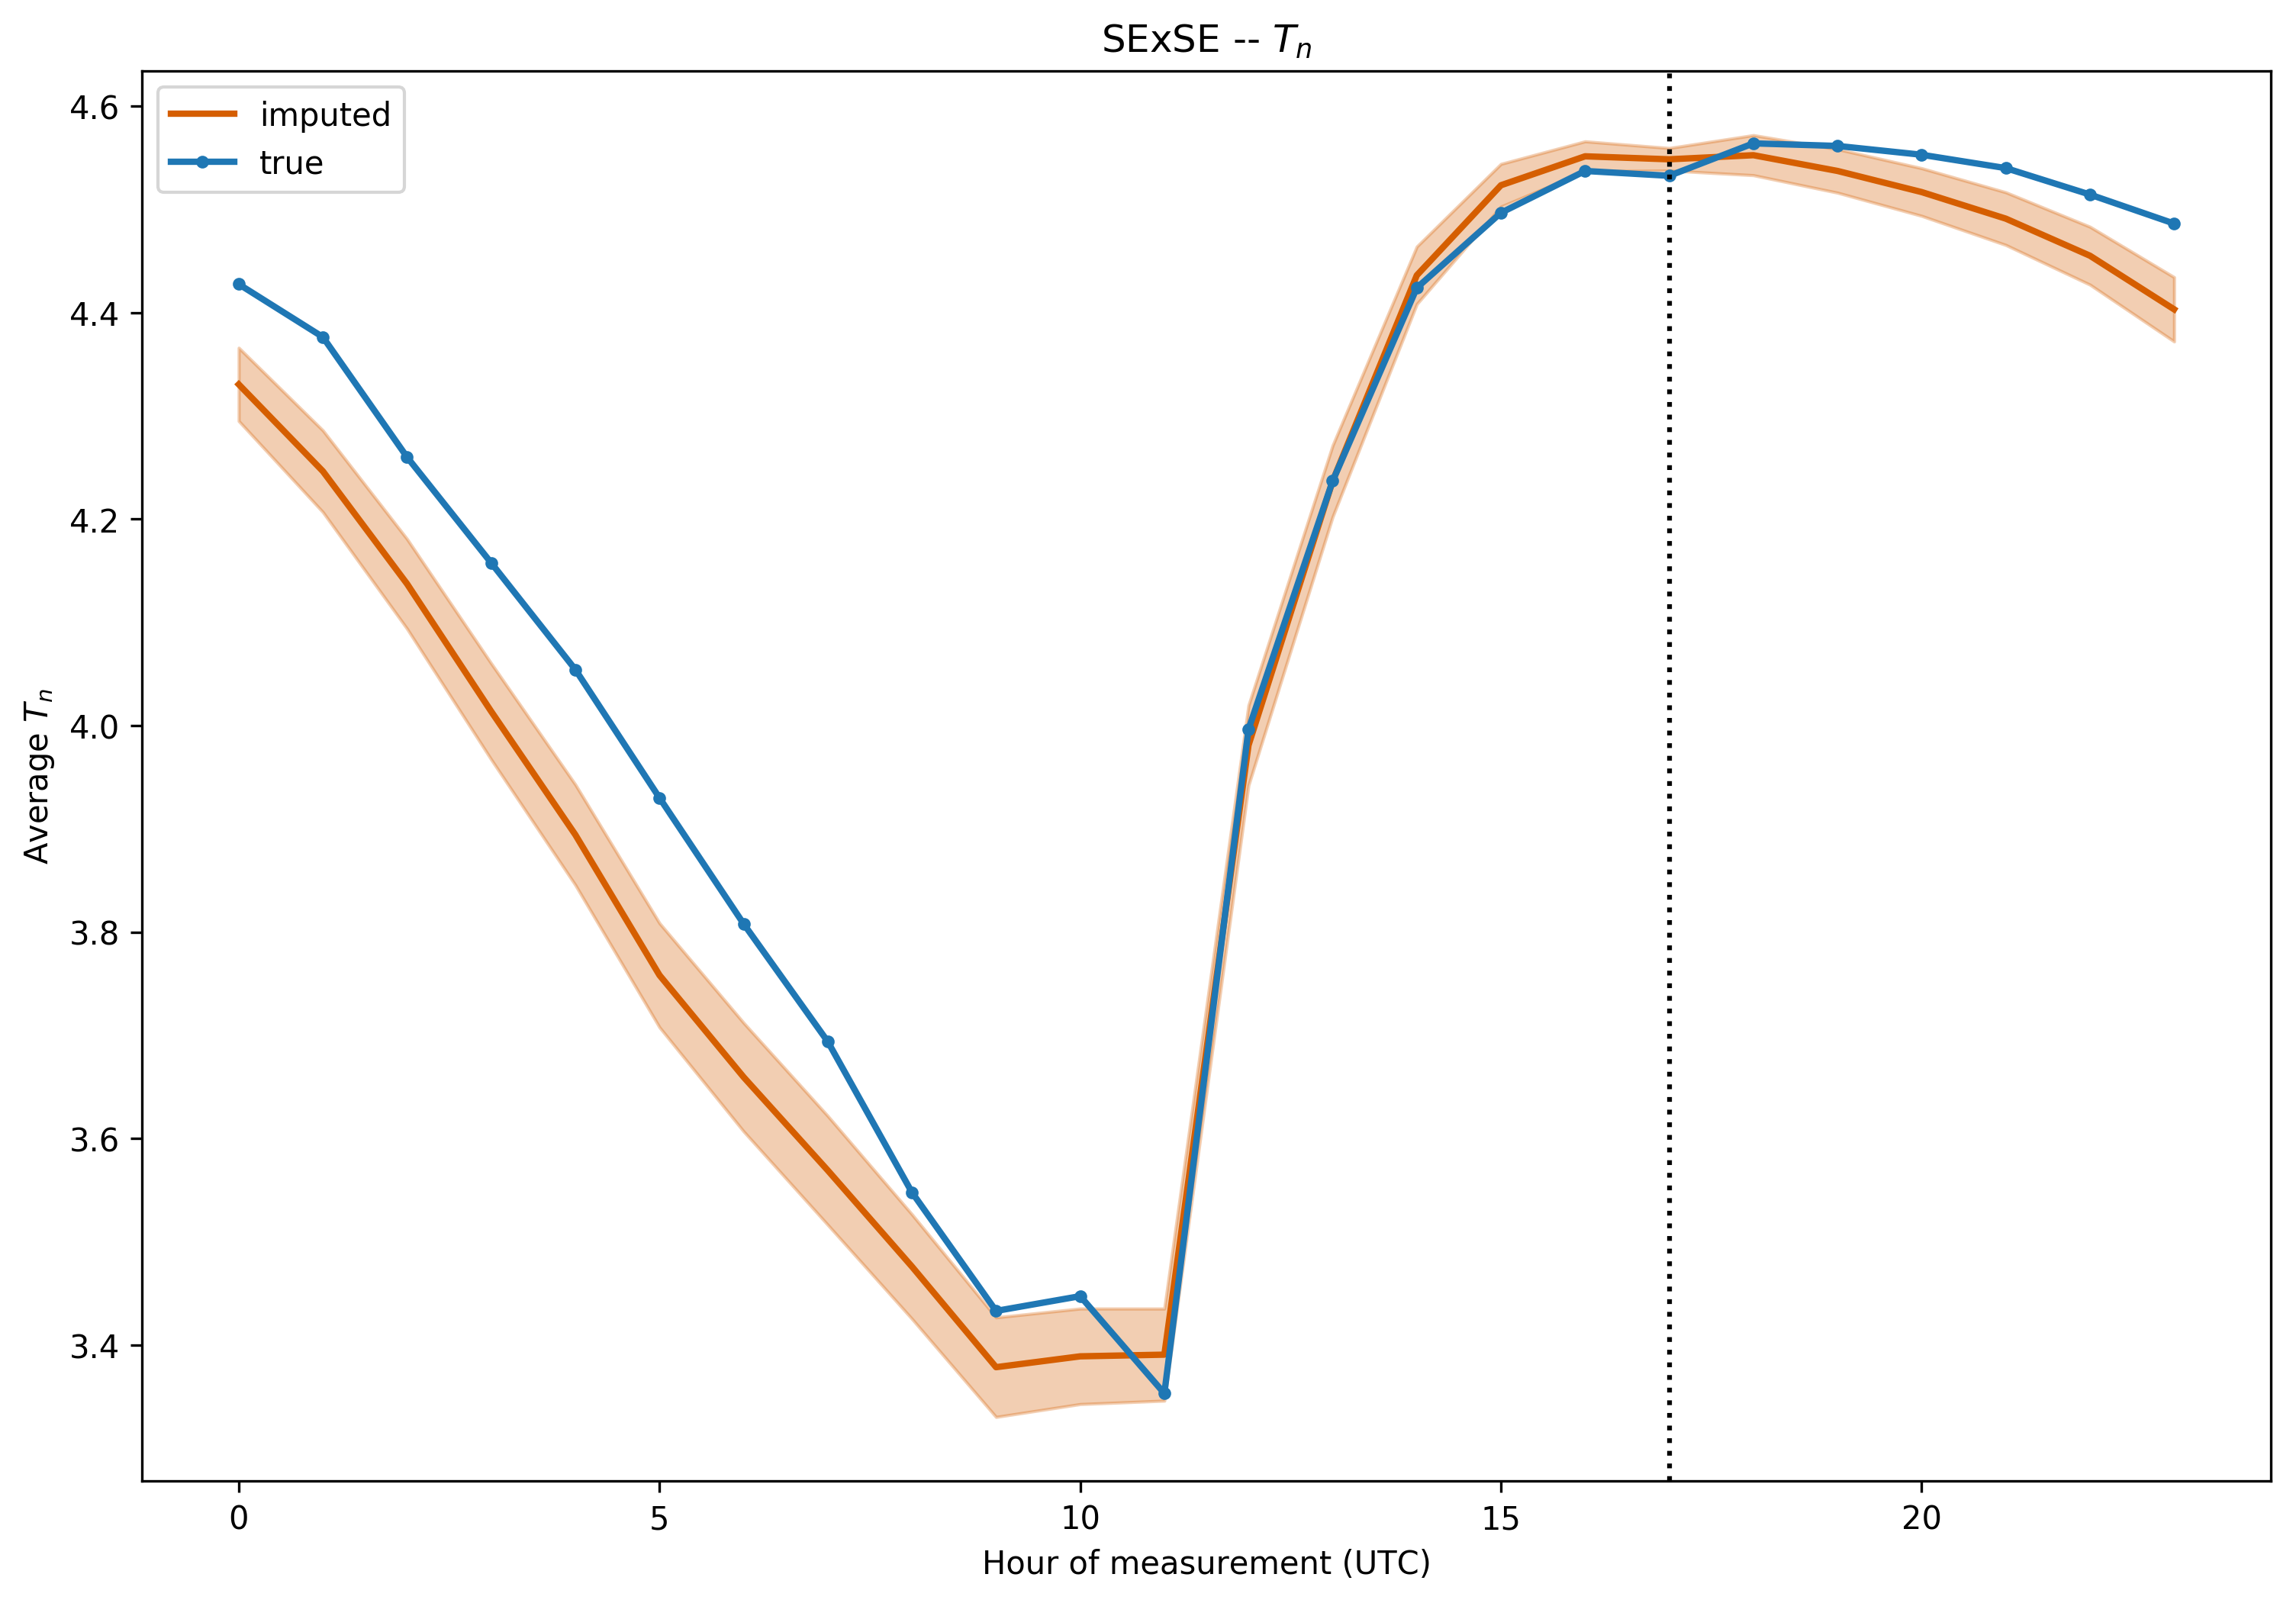

PyObject <matplotlib.text.Text object at 0x163f0eb50>

In [299]:
function plot_mean(all_hours_tntx_best, GPmodel::String, tntx::Symbol)
    cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
    y, y_err2, y_varcovar = mean_se(all_hours_tntx_best, GPmodel, tntx, minday, maxday)
    y_err = sqrt.(y_err2)
    y_sqrtvar = sqrt.(y_varcovar)
    plt.plot(0:23, y, 
             color=cbbPalette[6], 
             linewidth=2, 
             label="imputed")
    # plt.fill_between(0:23,
    #                  y.-2*y_err,
    #                  y.+2*y_err,
    #                  color=cbbPalette[6],
    #                  alpha=0.3
    #                  )
    plt.fill_between(0:23,
                     y.-2*y_sqrtvar,
                     y.+2*y_sqrtvar,
                     color=cbbPalette[6],
                     alpha=0.3
                     )
    plot_true_TnTx(tntx, mean, minday, maxday)

    plt.xlabel("Hour of measurement (UTC)")
    plt.axvline(x=17, color="black", linestyle=":")
    plt.legend(loc="best")
end
plot_mean(all_hours_tntx_best, "SExSE", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"SExSE -- $T_n$")

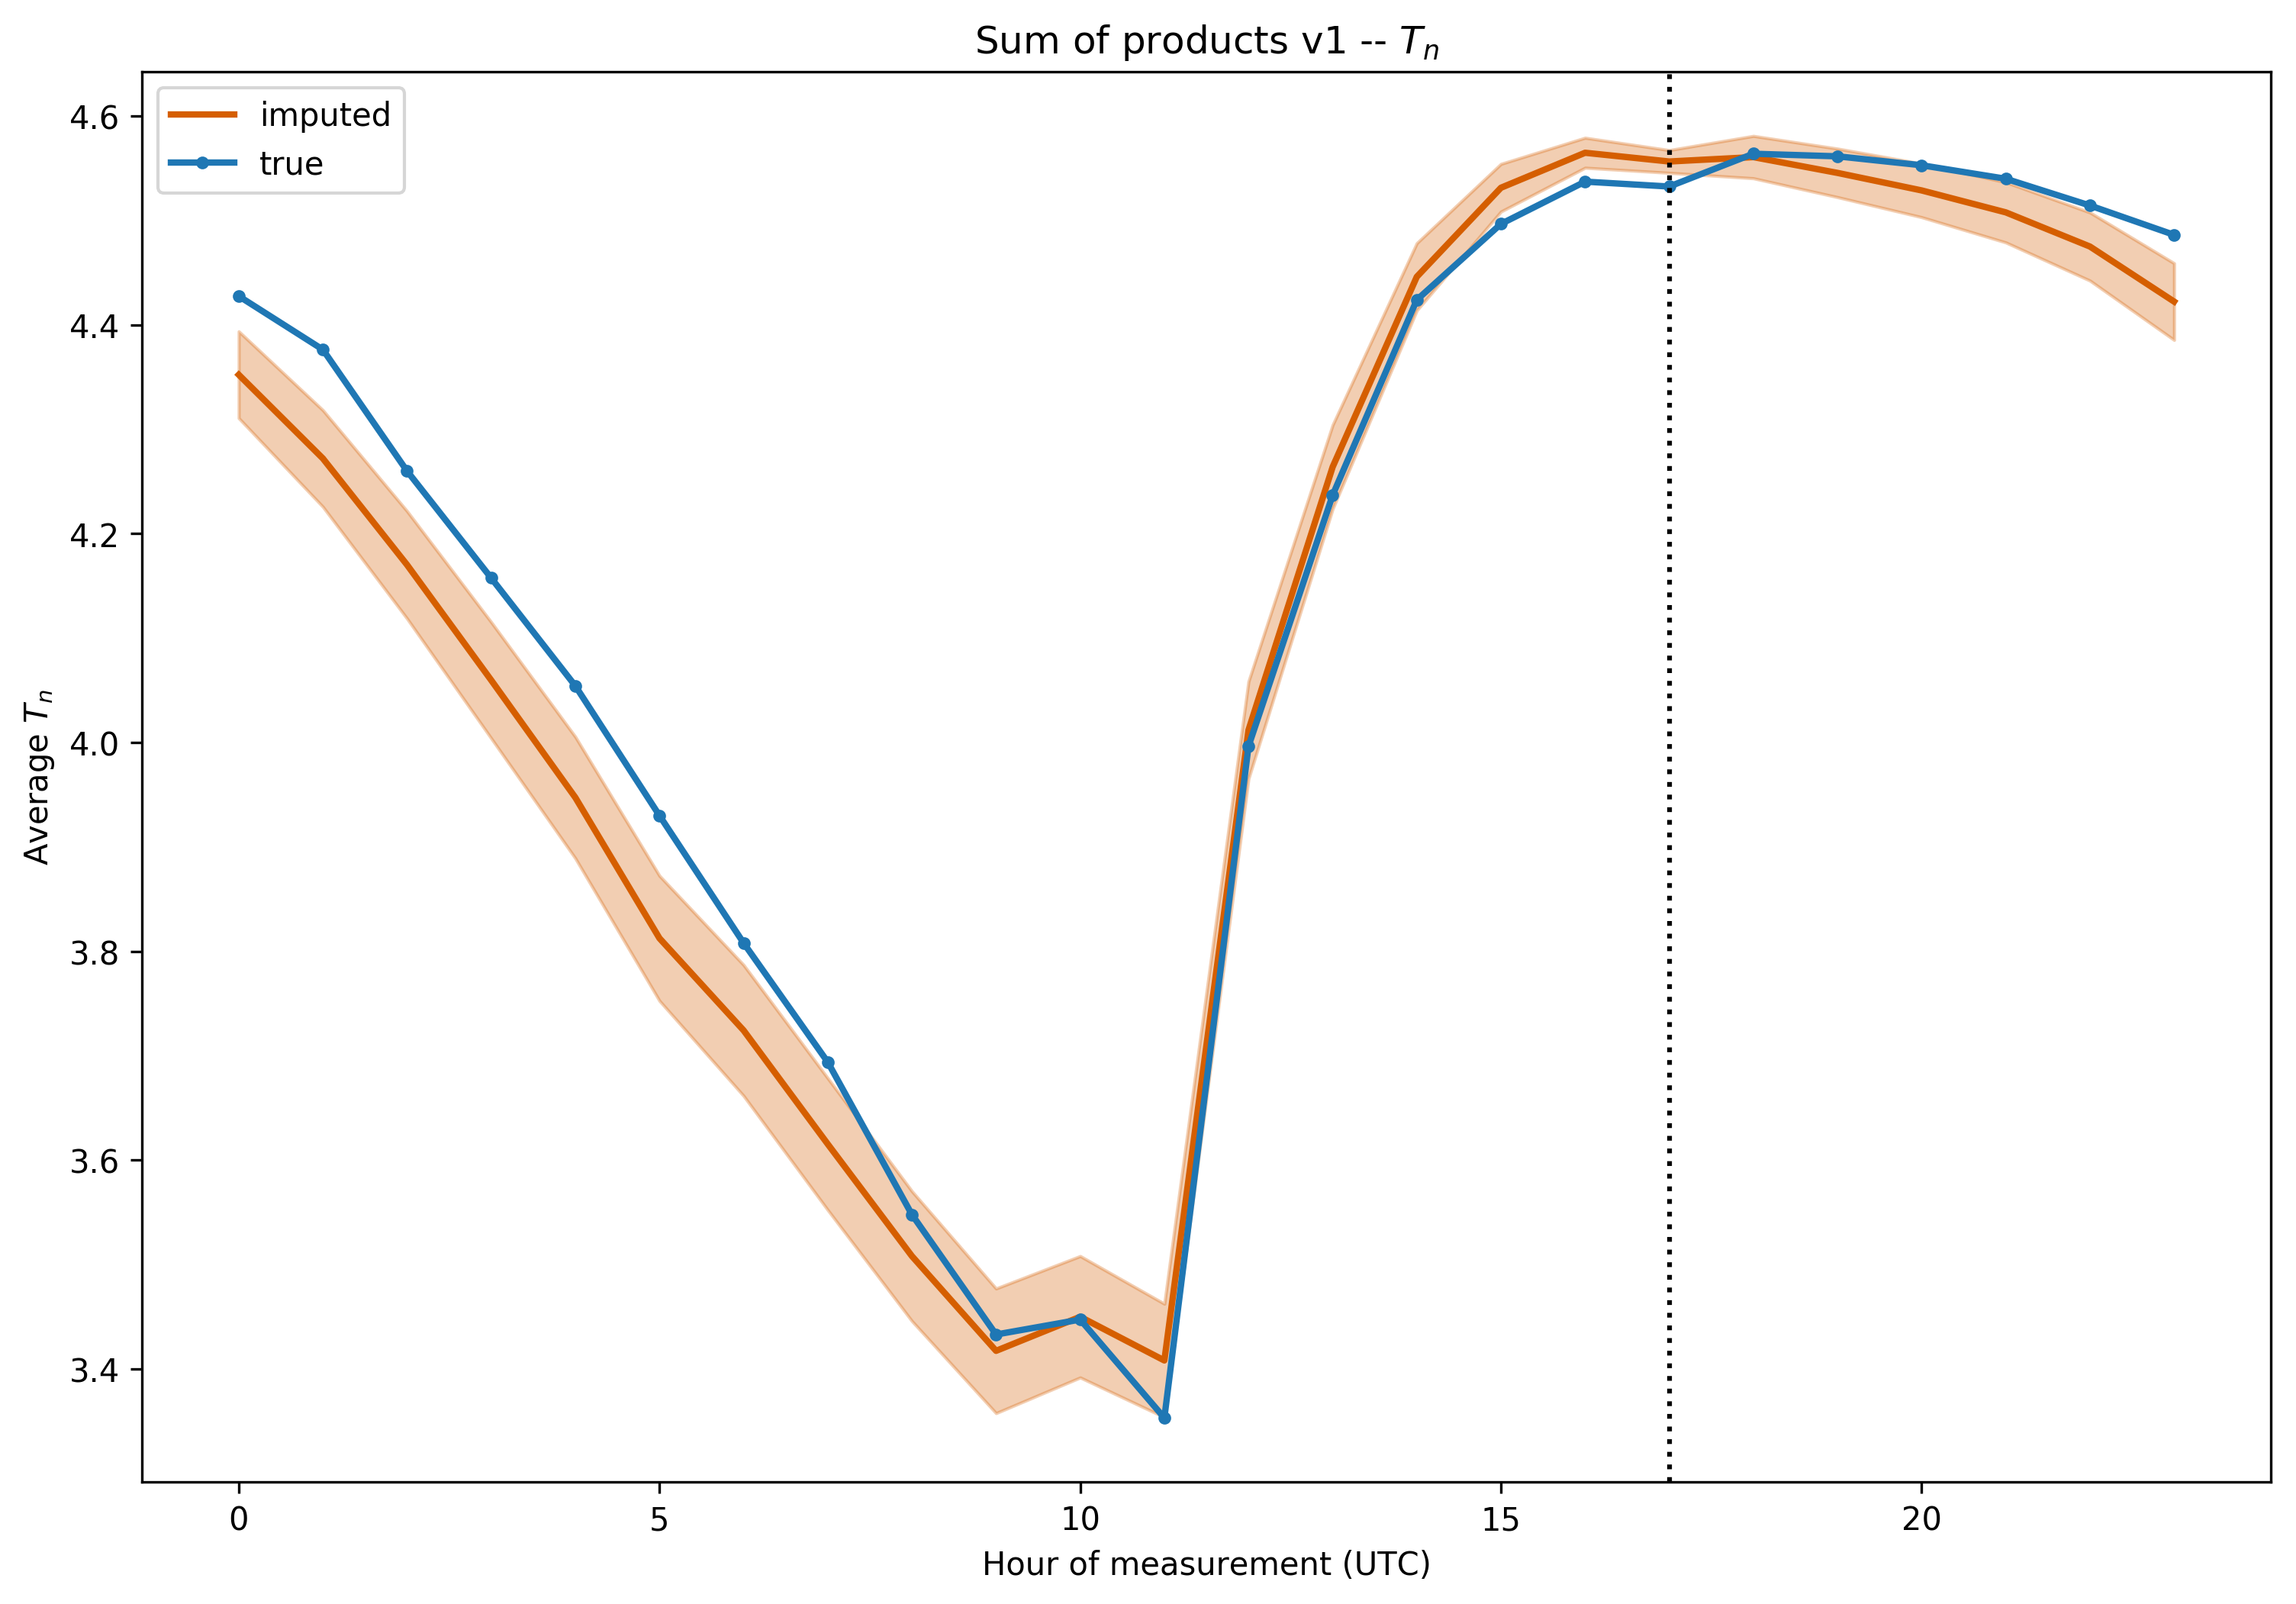

PyObject <matplotlib.text.Text object at 0x168ceaad0>

In [311]:
plot_mean(all_hours_tntx_best, "sumprod", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"Sum of products v1 -- $T_n$")

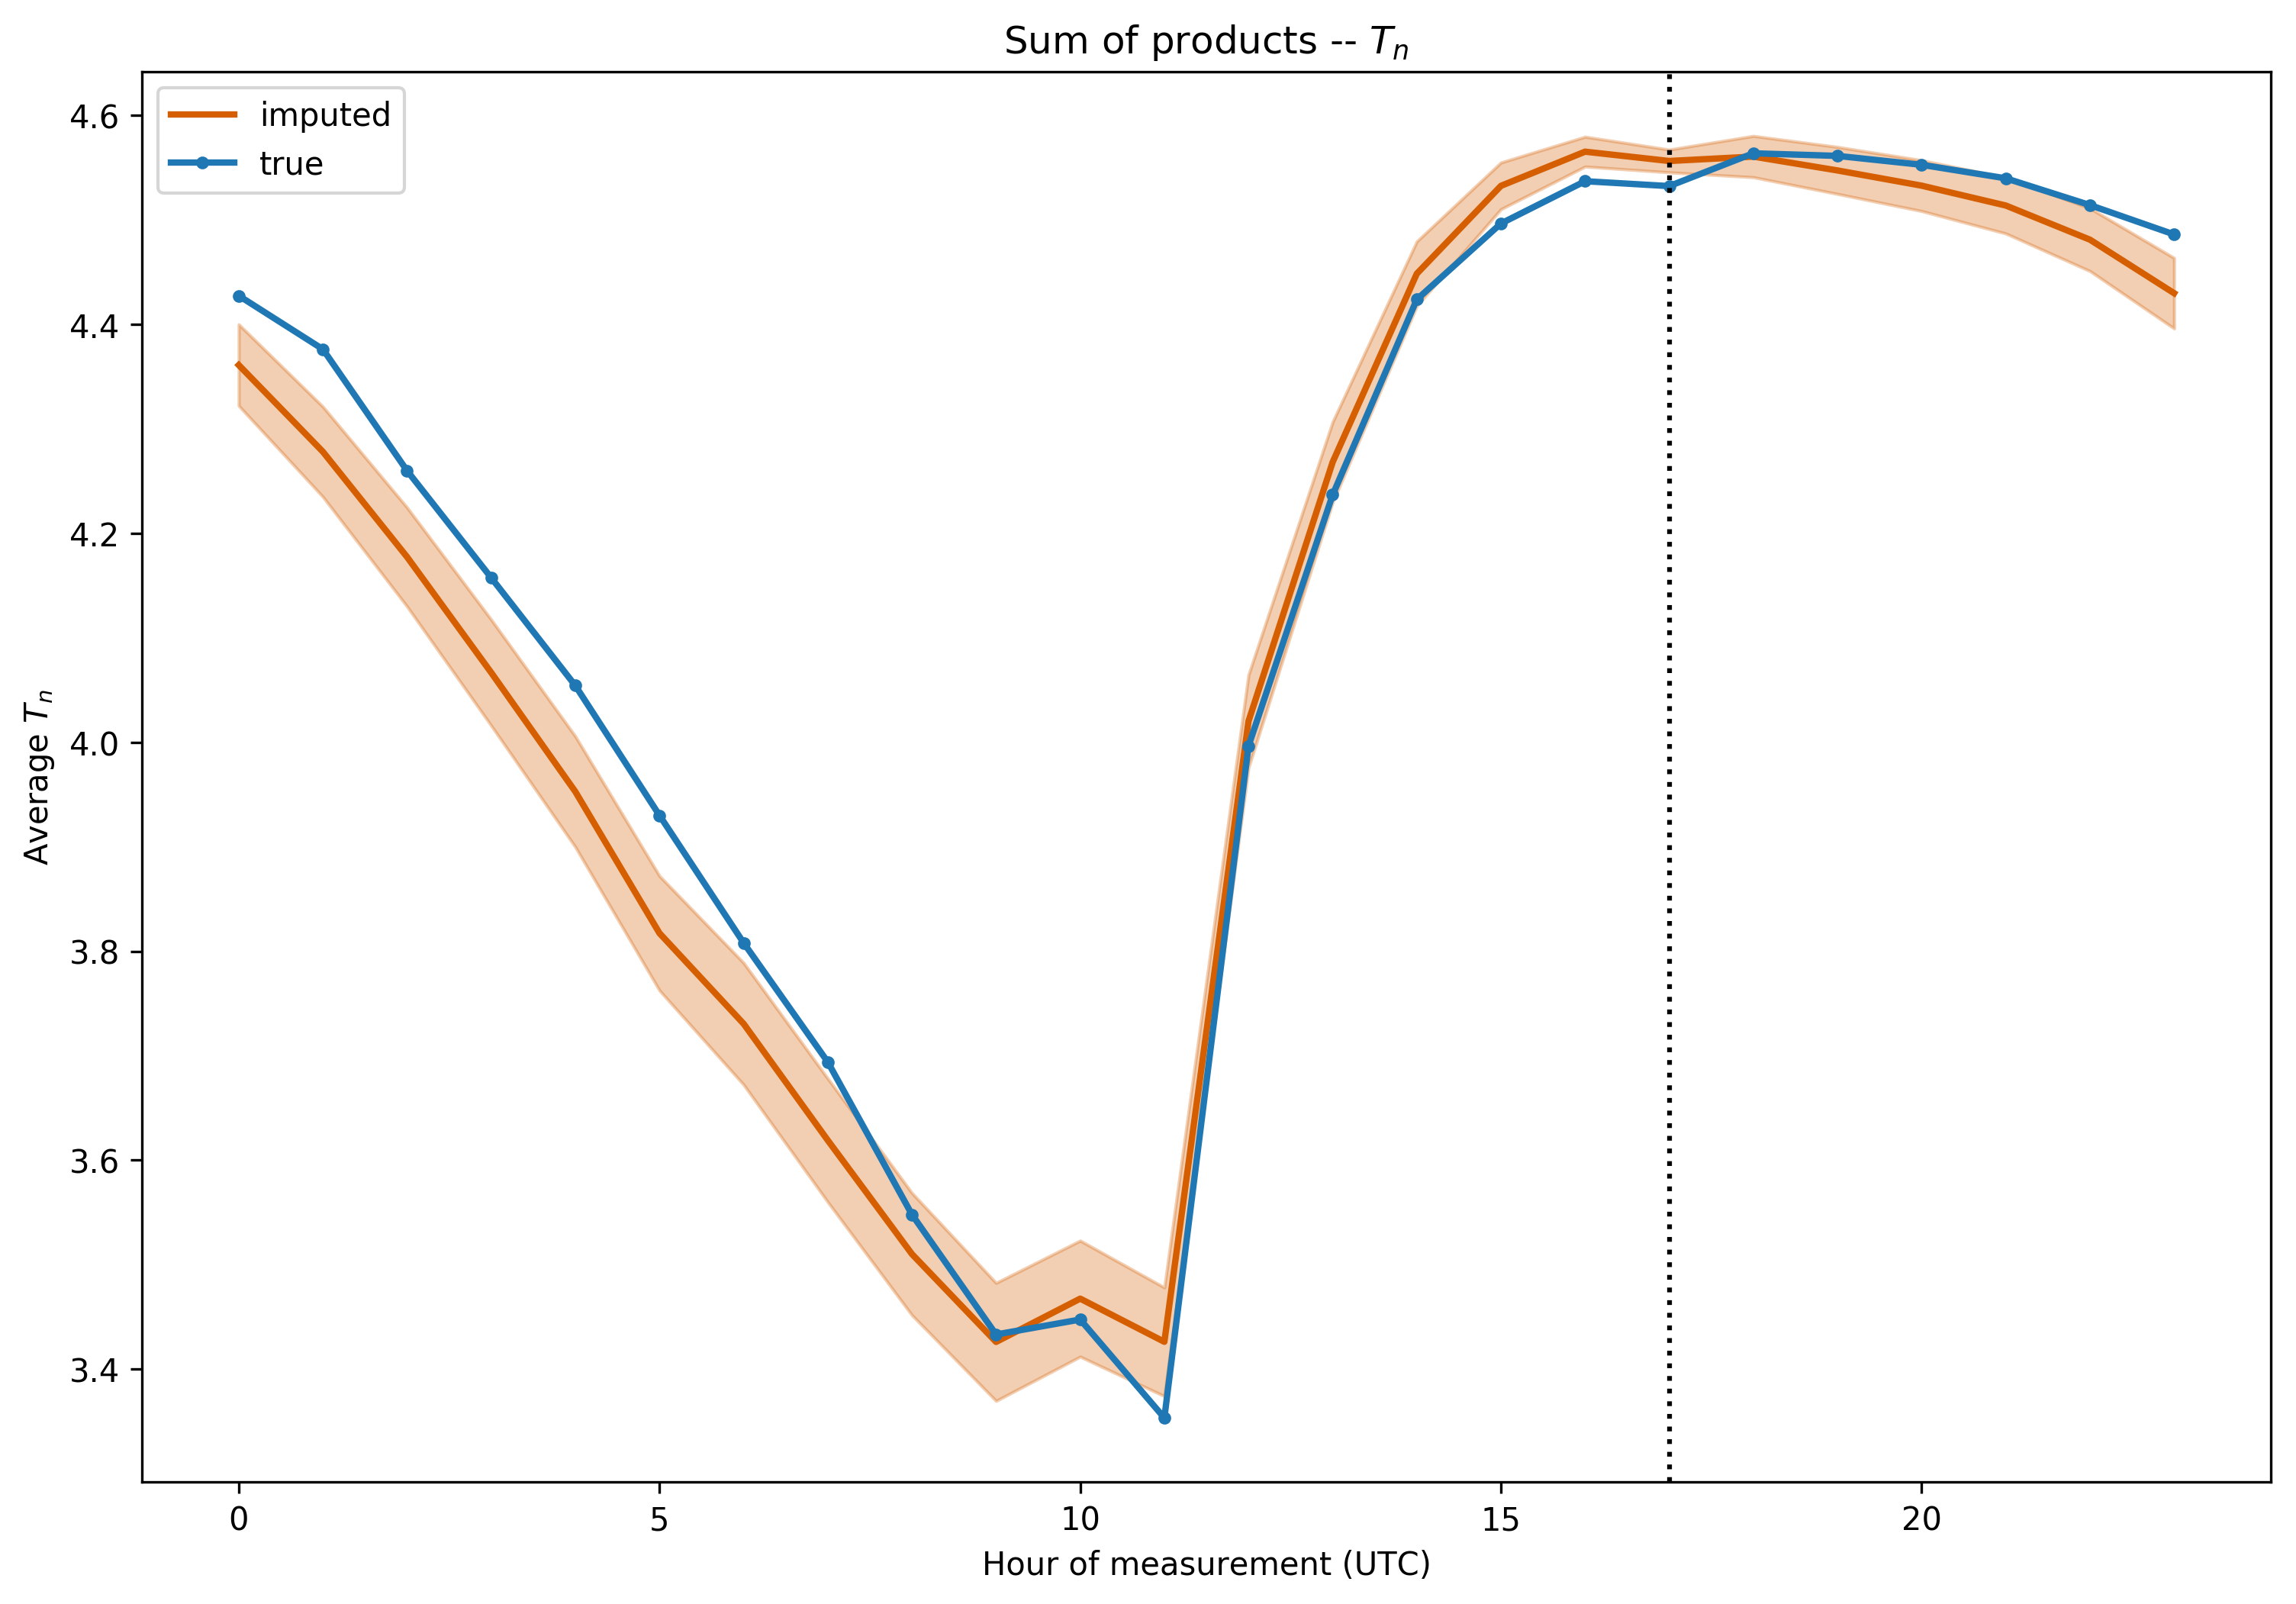

PyObject <matplotlib.text.Text object at 0x163fbd910>

In [300]:
plot_mean(all_hours_tntx_best, "simpler", :Tn)
plt.ylabel(L"Average $T_n$")
plt.title(L"Sum of products -- $T_n$")

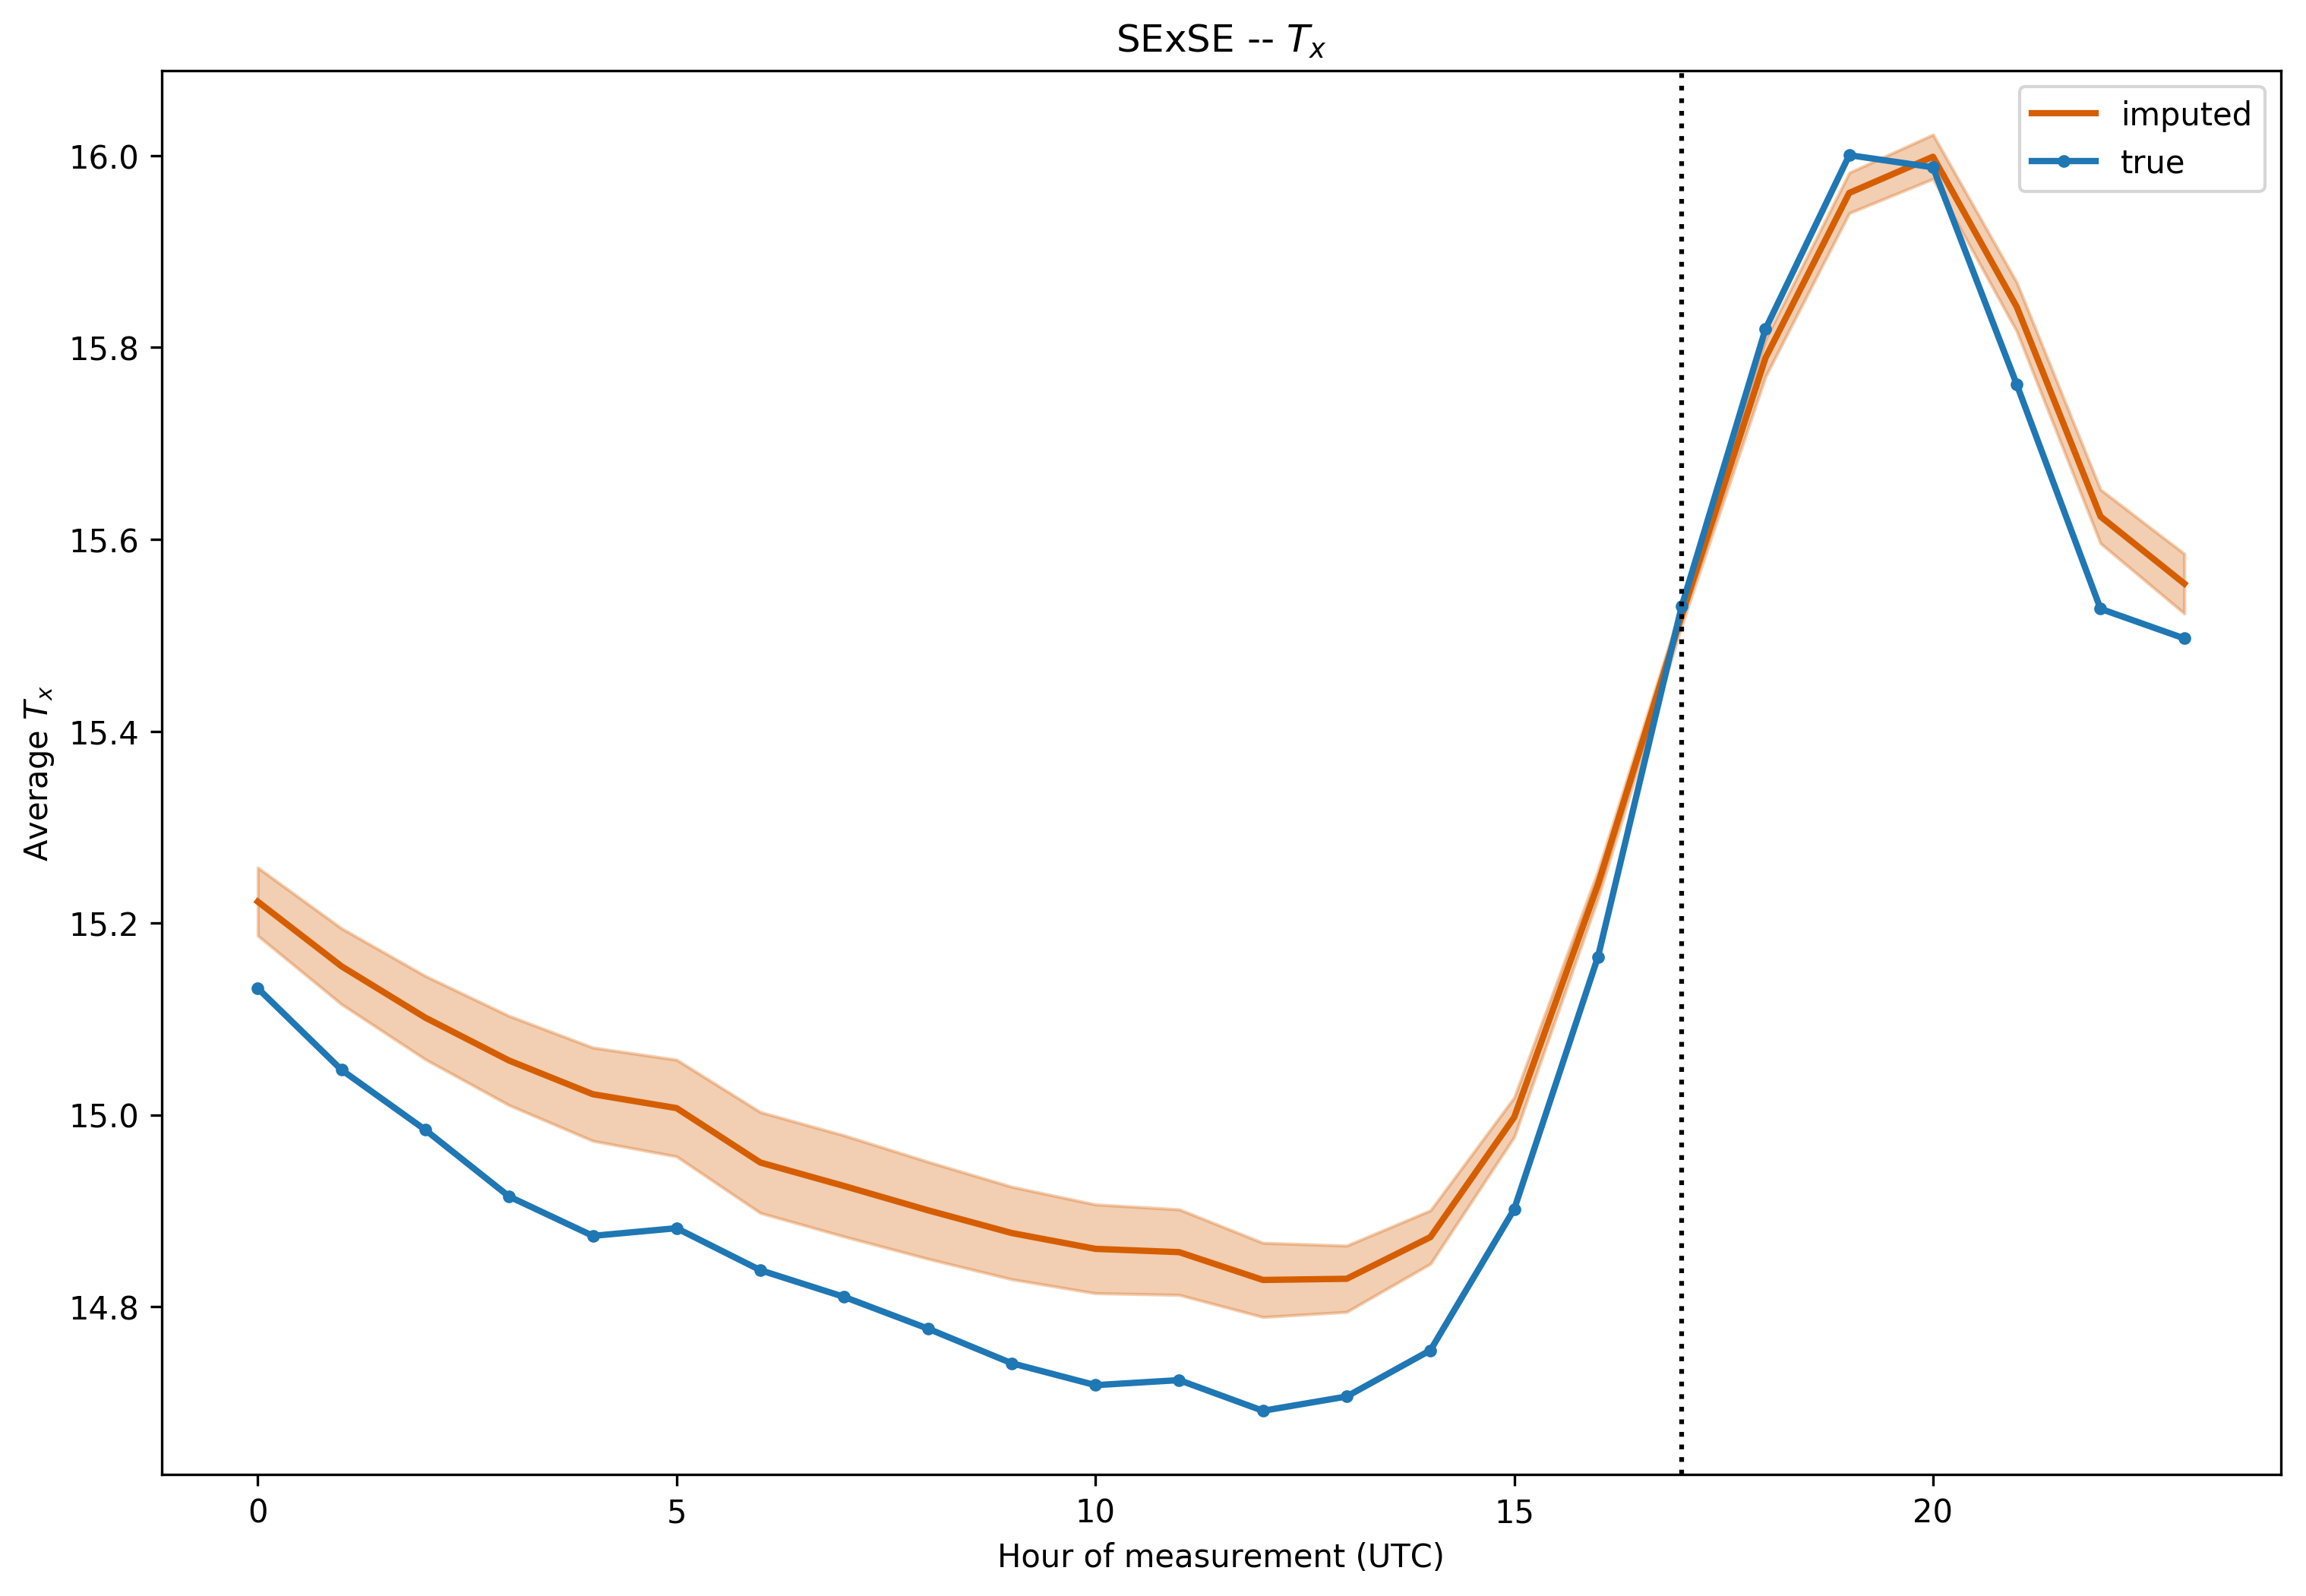

PyObject <matplotlib.text.Text object at 0x1645855d0>

In [304]:
plot_mean(all_hours_tntx_best, "SExSE", :Tx)
plt.ylabel(L"Average $T_x$")
plt.title(L"SExSE -- $T_x$")

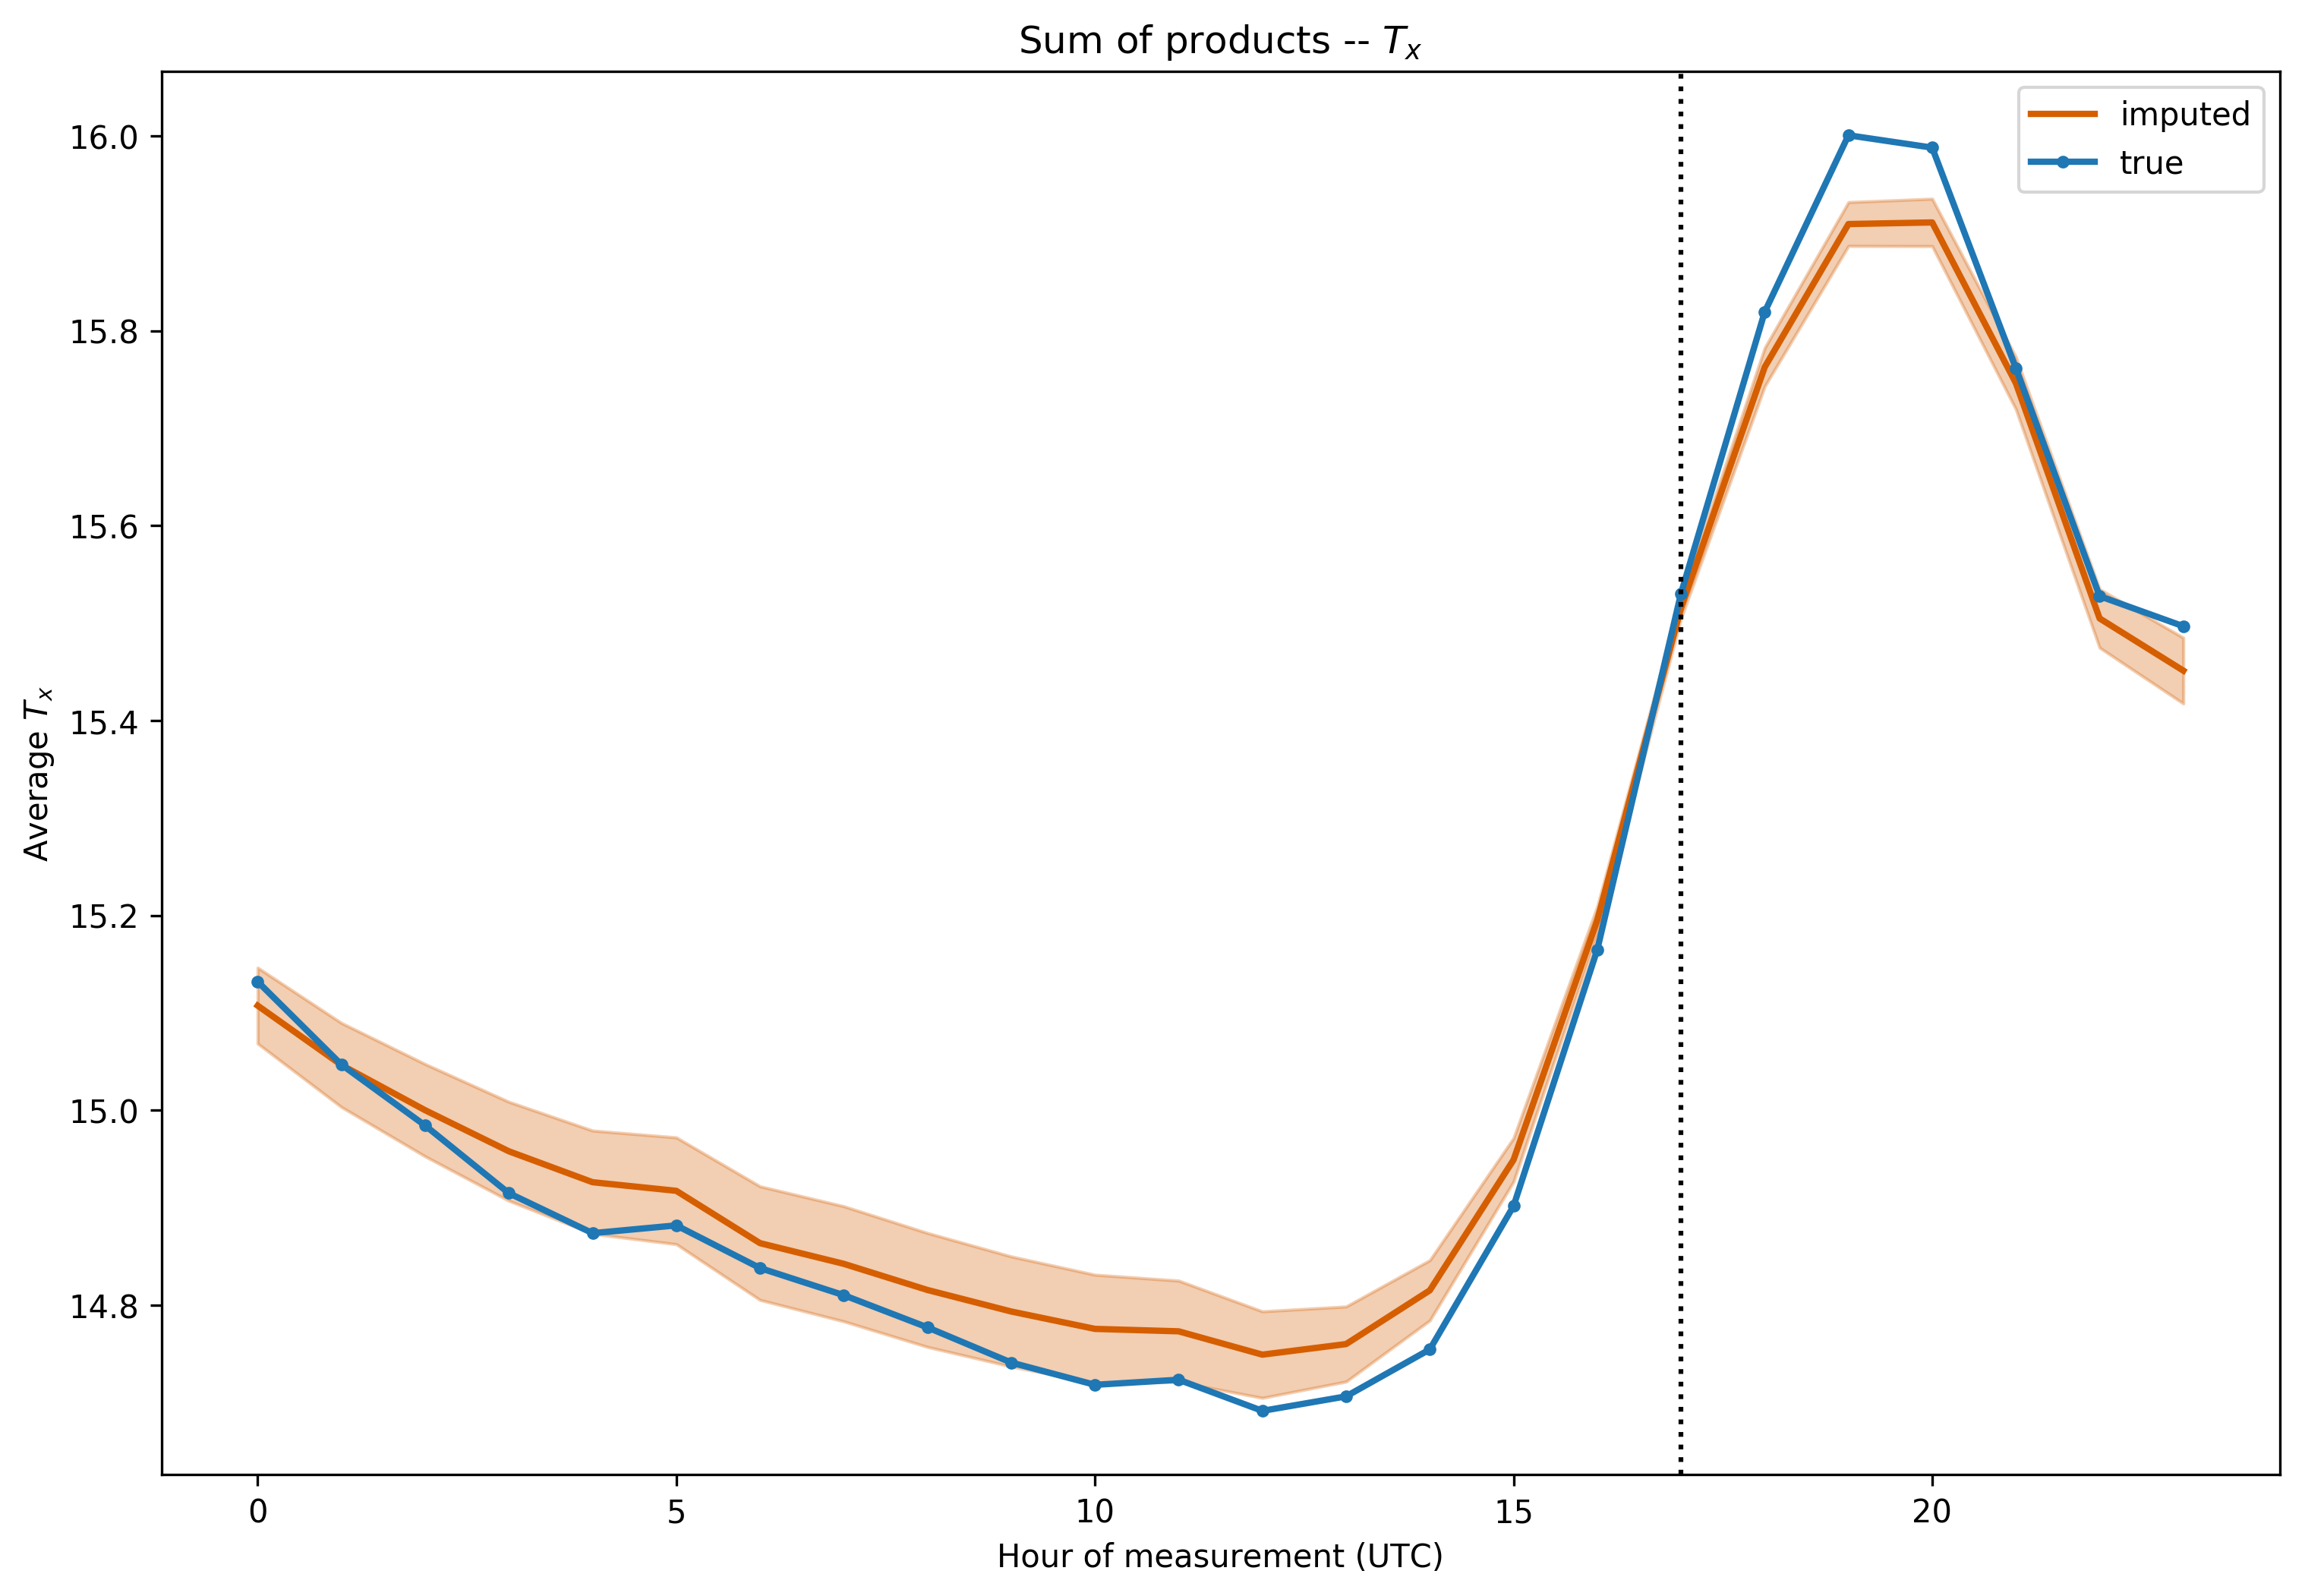

PyObject <matplotlib.text.Text object at 0x16449fb10>

In [303]:
plot_mean(all_hours_tntx_best, "simpler", :Tx)
plt.ylabel(L"Average $T_x$")
plt.title(L"Sum of products -- $T_x$")

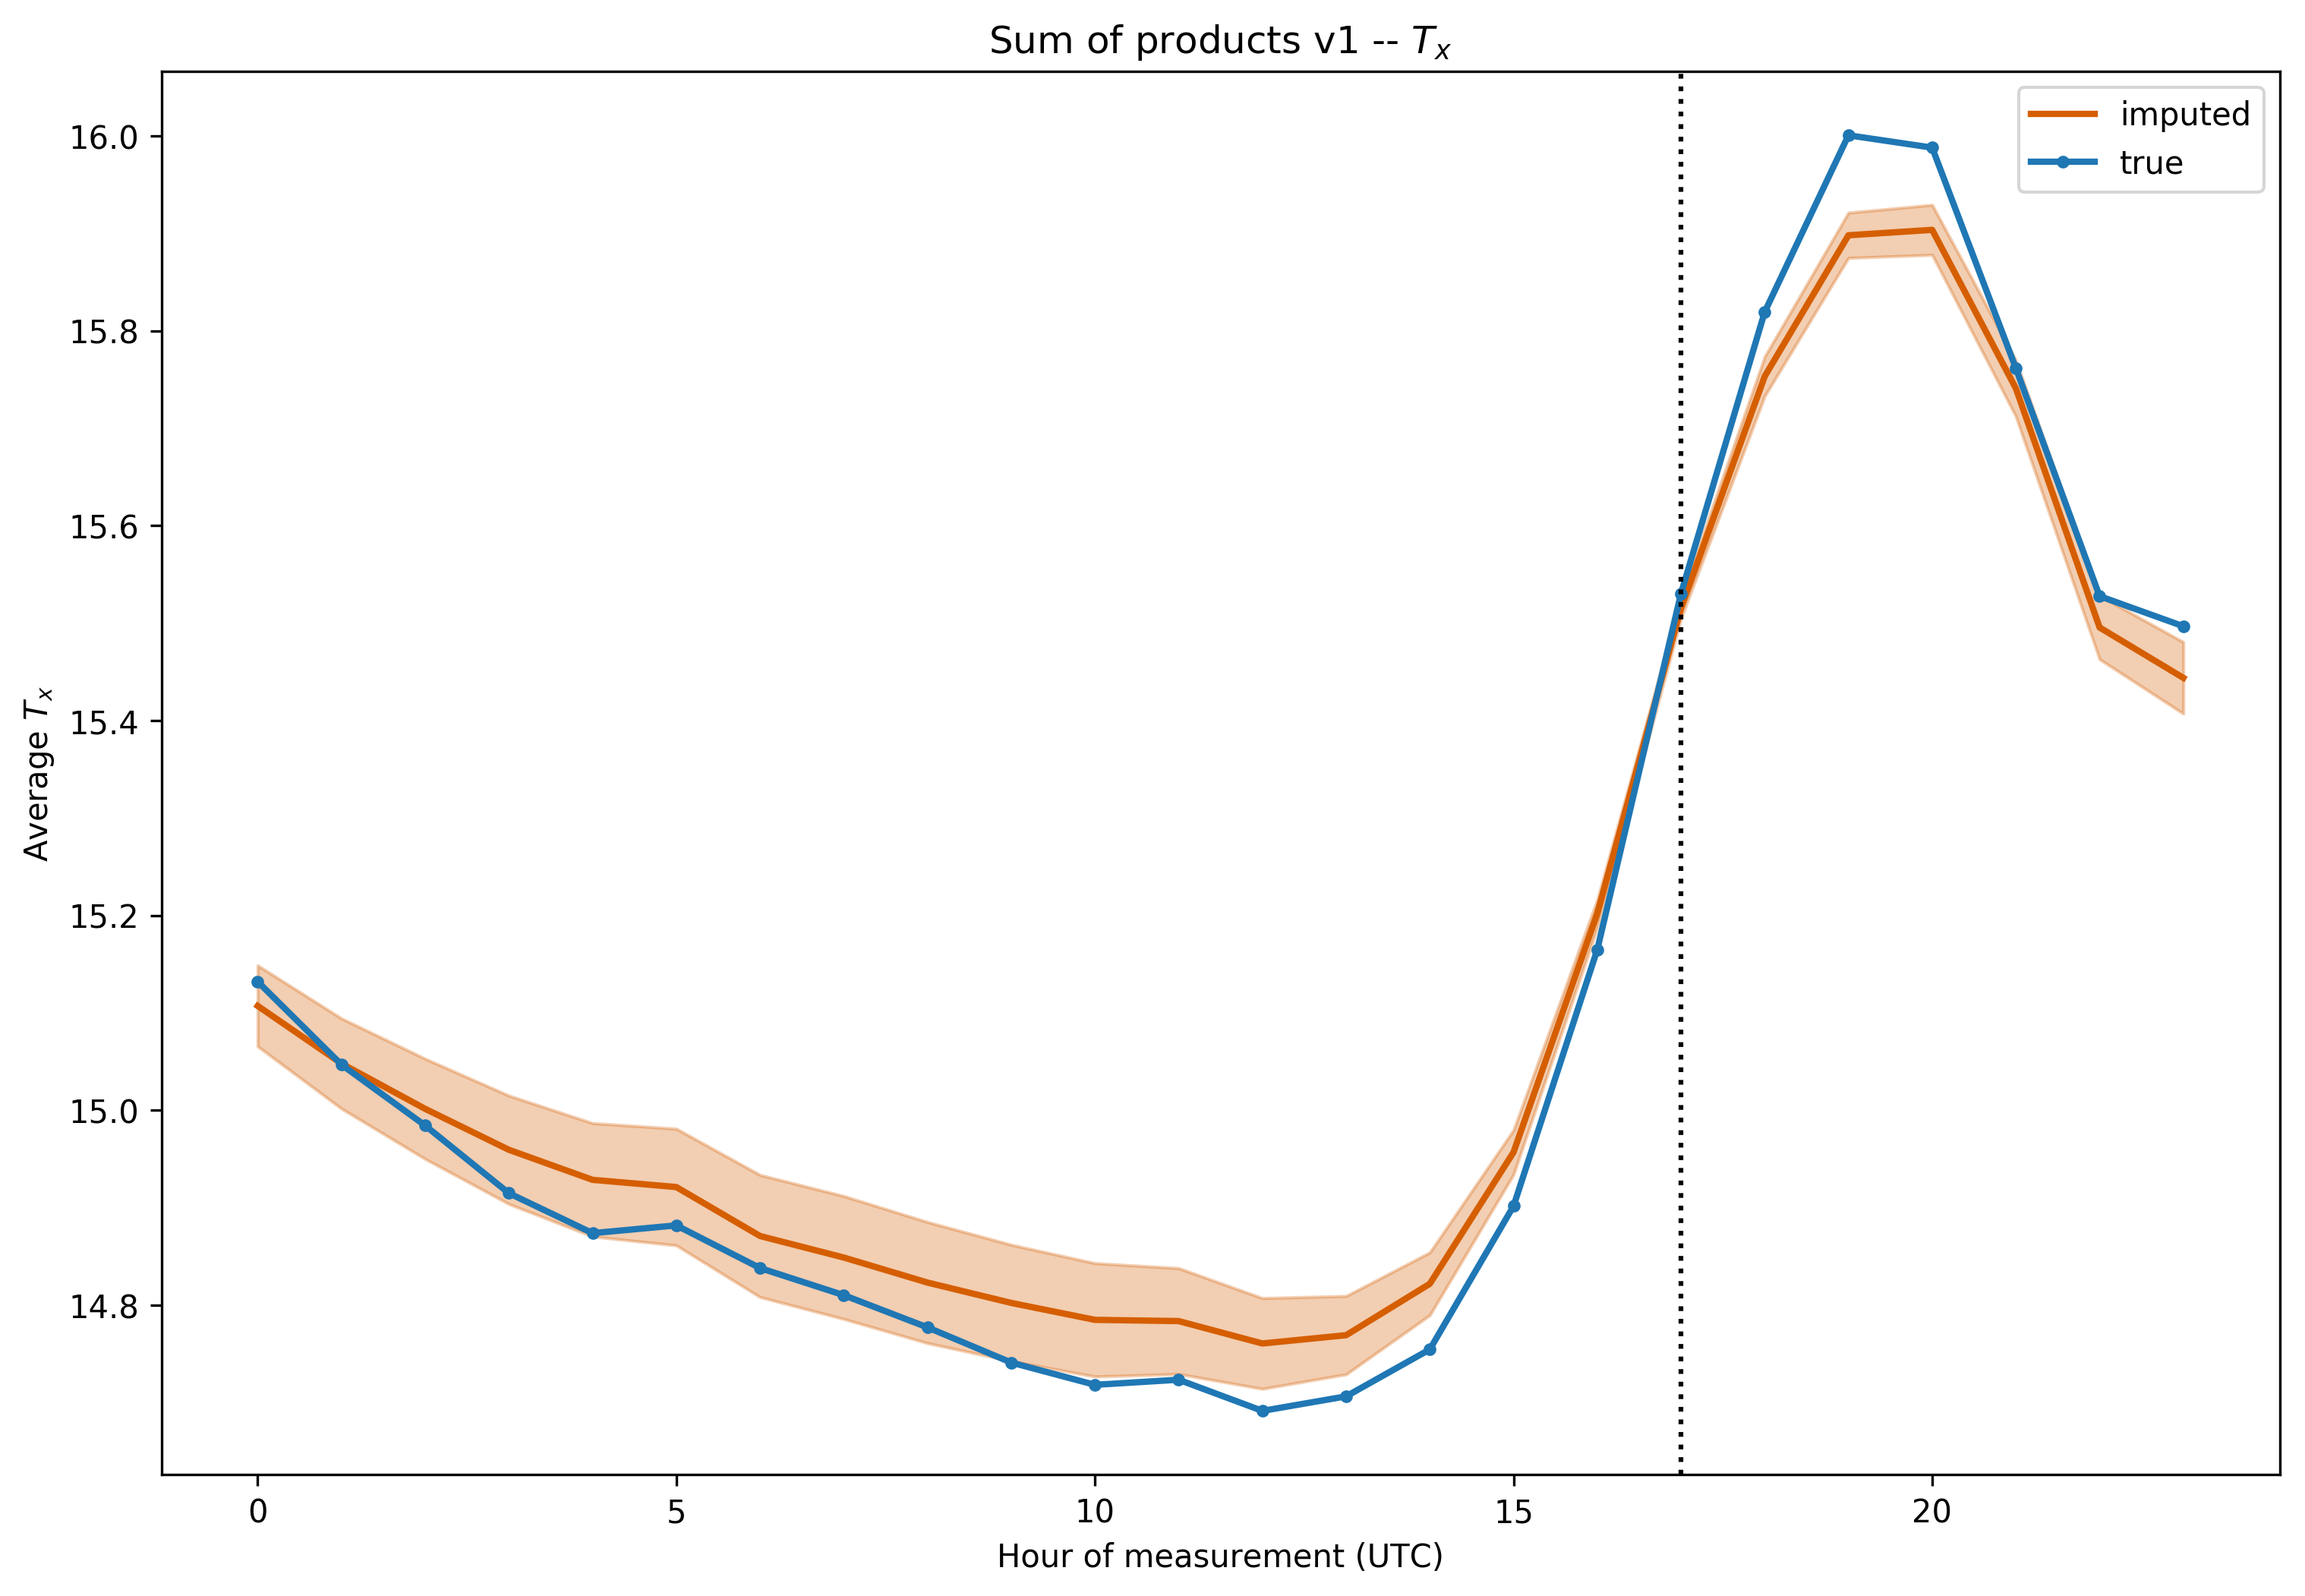

PyObject <matplotlib.text.Text object at 0x15c5e5fd0>

In [312]:
plot_mean(all_hours_tntx_best, "sumprod", :Tx)
plt.ylabel(L"Average $T_x$")
plt.title(L"Sum of products v1 -- $T_x$")